<a href="https://colab.research.google.com/github/Narcissist1/Cellari-Deeplearning-Course/blob/codelab/CellariTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from segnet import SegNet
from unet import UNet
from torch.optim import lr_scheduler

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [229]:
if use_cuda:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if use_cuda:
    path_to_images = '/content/drive/My Drive/train/raw_images'
    path_to_annotations = '/content/drive/My Drive/train/annotations_white'
else:
    path_to_images = 'train/raw_images'
    path_to_annotations = 'train/annotations_white'

transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.RandomCrop(size=(128, 128)),
    
    torchvision.transforms.RandomHorizontalFlip(0.5),
    
    torchvision.transforms.RandomVerticalFlip(0.5),
    
    torchvision.transforms.ToTensor()
])

transform_observe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    torchvision.transforms.ToTensor()
])


# Unet resize transform
transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.Resize((212, 212)),
    
    torchvision.transforms.ToTensor()
])

data_norm = torchvision.transforms.Normalize(mean=[0.78092086, 0.5018261, 0.7803567],
                                 std=[0.16727196, 0.24176046, 0.13103652])
# anno_norm =  torchvision.transforms.Normalize(mean=[0.00202586], std=[0.00176733])


class CustomDataset(Dataset):
    
    def __init__(self, img_list, anno_list, num_of_classes=2, transform=None):
        
        self.img_list = img_list
        self.anno_list = anno_list
        self.num_of_classes = num_of_classes
        self.transform = transform
        
    def __getitem__(self, img_id):
        
        image = Image.open(img_list[img_id])
        img = np.array(image)
        anno = np.array(Image.open(self.anno_list[img_id]).convert("L"))

        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform:
            img = self.transform(img)
            img = data_norm(img)
            random.seed(seed)
            anno = self.transform(anno)
            # anno = transform_resize(anno)     # unet resize

        anno[anno>0] = 1
        # anno_reshaped = np.zeros((self.num_of_classes, anno.shape[1], anno.shape[2]))
        # for i in range(self.num_of_classes):
        #     anno_reshaped[i, :, :][anno[0] == i] = 1

        sample = {"image": img, "annotation": anno}
        return sample
    
    
    def __len__(self):
        return len(self.img_list)

img_list = glob.glob(path_to_images + os.sep + "*.bmp")
img_list = sorted(img_list)
anno_list = glob.glob(path_to_annotations + os.sep + "*.bmp")
anno_list = sorted(anno_list)
dataset_train = CustomDataset(img_list, anno_list, 2, transform=transform_pipe)
dataset_observe = CustomDataset(img_list, anno_list, 2, transform=transform_observe)

In [0]:
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 50,
    shuffle=True
)

dataloader_observe = torch.utils.data.DataLoader(
    dataset_observe,
    batch_size = 1,
    shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50, 3, 128, 128)


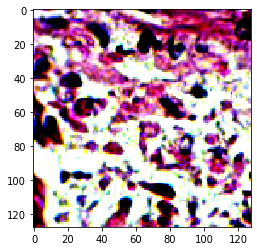

torch.Size([50, 1, 128, 128])


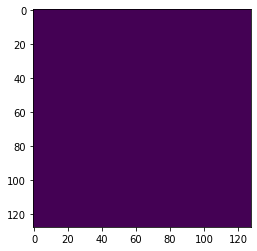

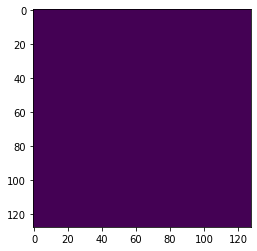

In [232]:
data = [batch_data for batch_data in dataloader_train]
batch_data = data[0]
fig_img = plt.figure()
print(batch_data['image'].numpy().shape)
plt.imshow(batch_data['image'][0].permute(1, 2, 0).numpy())
plt.show()
print(batch_data['annotation'].shape)
batch_data['annotation'] = batch_data['annotation']
plt.imshow(batch_data['annotation'][0][0])
fig_img.suptitle('image')
plt.show()
plt.imshow(batch_data['annotation'][1][0])
plt.show()

In [0]:
net = SegNet(1, n_init_features=3) # input channels, output channels
# net = UNet(1, n_init_features=3)
if use_cuda:
    net.cuda()

In [0]:
LEARNING_RATE = 0.001
criterion = nn.BCEWithLogitsLoss() 

# optimizer = optim.SGD(net.parameters(), LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), 5e-5, (0.9, 0.999),  eps=1e-08, weight_decay=1e-1)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.1)


train loss:  0.7264285087585449


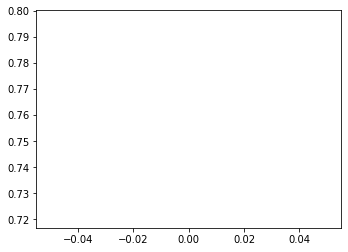

Train, it: 0 loss: 0.76
train loss:  0.7672683596611023


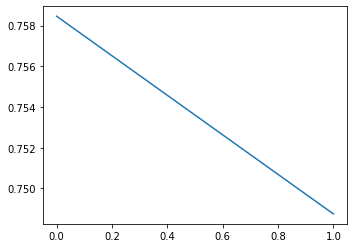

Train, it: 1 loss: 0.75
train loss:  0.7440875768661499


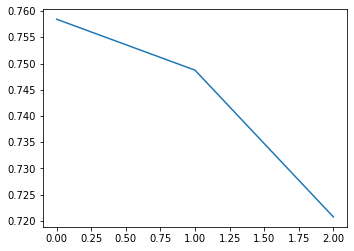

Train, it: 2 loss: 0.72
train loss:  0.7310541272163391


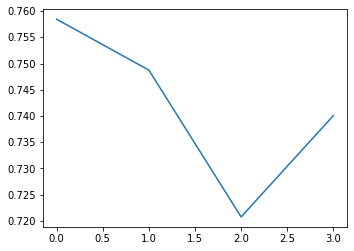

Train, it: 3 loss: 0.74
train loss:  0.7364228367805481


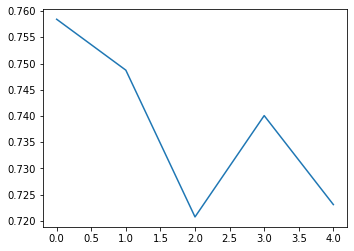

Train, it: 4 loss: 0.72
train loss:  0.7577823400497437


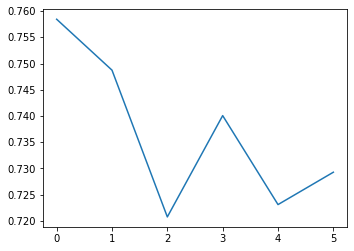

Train, it: 5 loss: 0.73
train loss:  0.7319173812866211


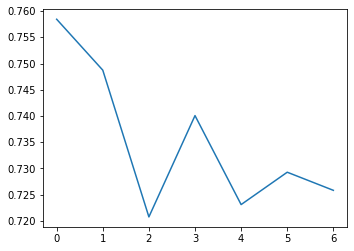

Train, it: 6 loss: 0.73
train loss:  0.7084493637084961


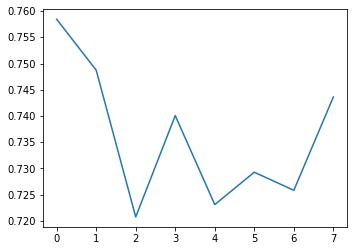

Train, it: 7 loss: 0.74
train loss:  0.7192832827568054


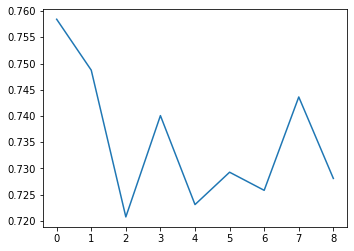

Train, it: 8 loss: 0.73
train loss:  0.7043662667274475


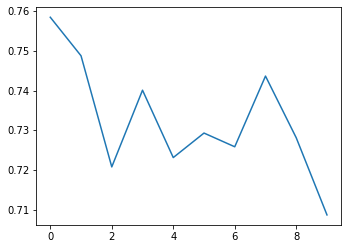

Train, it: 9 loss: 0.71
train loss:  0.7080470323562622


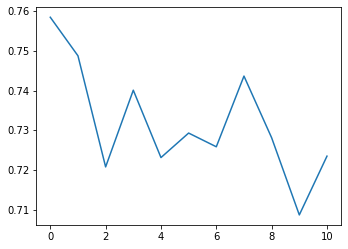

Train, it: 10 loss: 0.72
train loss:  0.6919724941253662


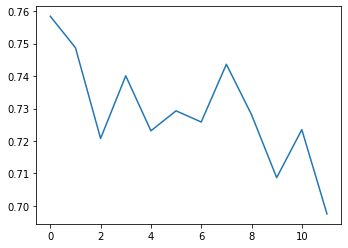

Train, it: 11 loss: 0.70
train loss:  0.7034525871276855


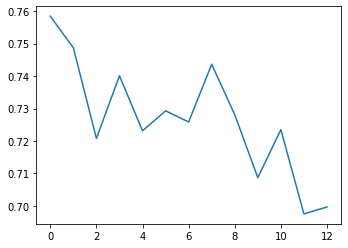

Train, it: 12 loss: 0.70
train loss:  0.7279298305511475


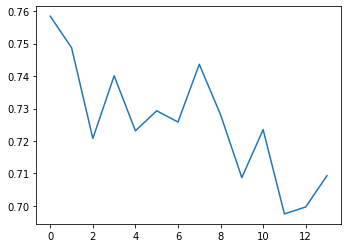

Train, it: 13 loss: 0.71
train loss:  0.7034924030303955


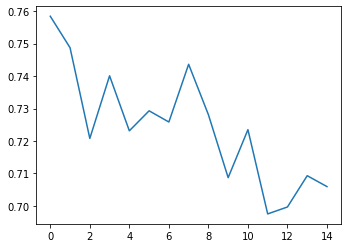

Train, it: 14 loss: 0.71
train loss:  0.7199325561523438


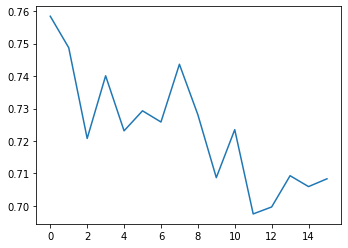

Train, it: 15 loss: 0.71
train loss:  0.7015121579170227


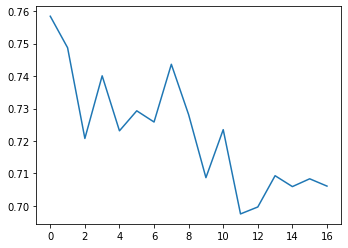

Train, it: 16 loss: 0.71
train loss:  0.7056018114089966


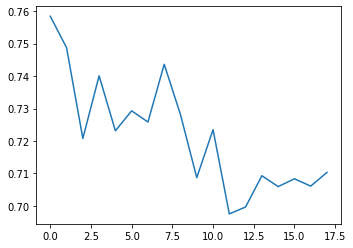

Train, it: 17 loss: 0.71
train loss:  0.7282759547233582


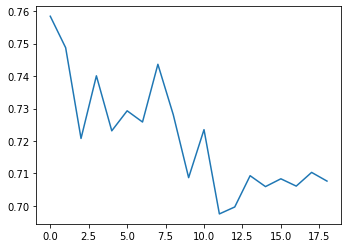

Train, it: 18 loss: 0.71
train loss:  0.7044975161552429


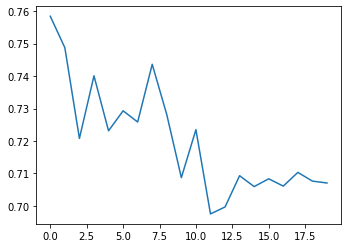

Train, it: 19 loss: 0.71
train loss:  0.7080219984054565


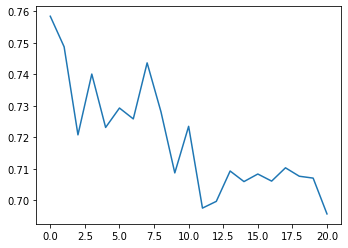

Train, it: 20 loss: 0.70
train loss:  0.7078734636306763


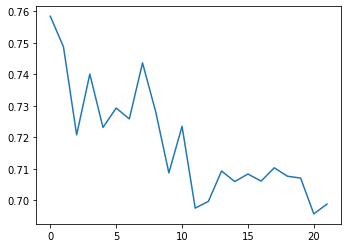

Train, it: 21 loss: 0.70
train loss:  0.6906934976577759


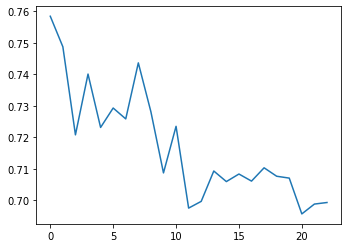

Train, it: 22 loss: 0.70
train loss:  0.7015582323074341


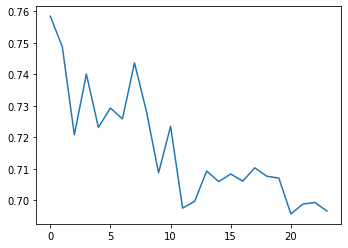

Train, it: 23 loss: 0.70
train loss:  0.7088353037834167


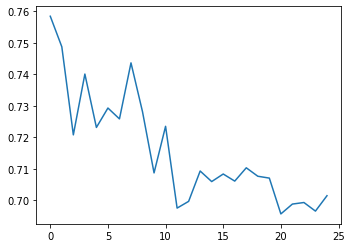

Train, it: 24 loss: 0.70
train loss:  0.6899415254592896


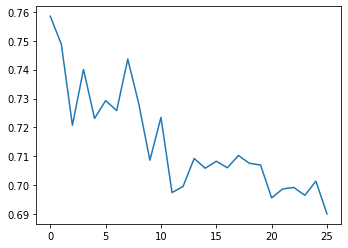

Train, it: 25 loss: 0.69
train loss:  0.6785671710968018


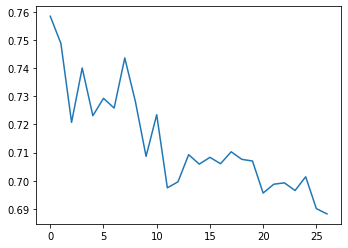

Train, it: 26 loss: 0.69
train loss:  0.6746211647987366


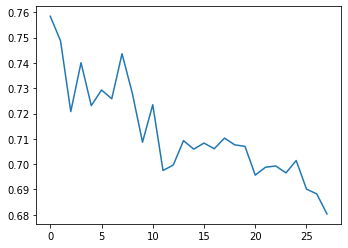

Train, it: 27 loss: 0.68
train loss:  0.6889605522155762


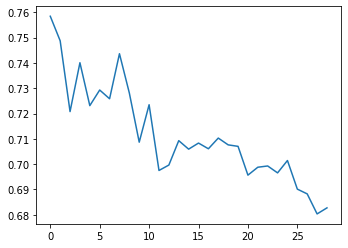

Train, it: 28 loss: 0.68
train loss:  0.7000732421875


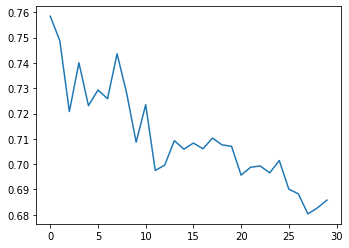

Train, it: 29 loss: 0.69
train loss:  0.6858116984367371


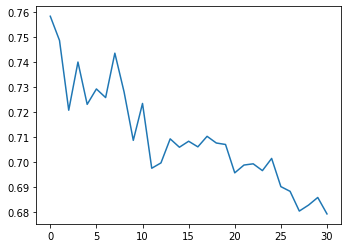

Train, it: 30 loss: 0.68
train loss:  0.6679049730300903


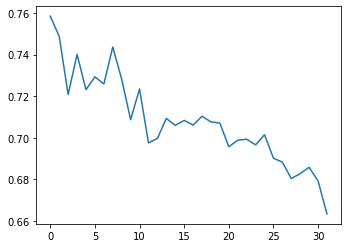

Train, it: 31 loss: 0.66
train loss:  0.6662910580635071


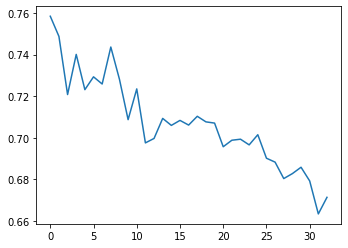

Train, it: 32 loss: 0.67
train loss:  0.6738737225532532


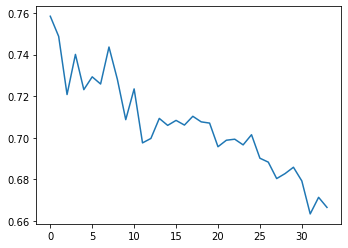

Train, it: 33 loss: 0.67
train loss:  0.6646549105644226


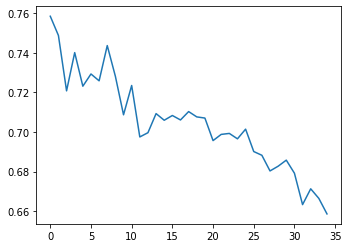

Train, it: 34 loss: 0.66
train loss:  0.6557614207267761


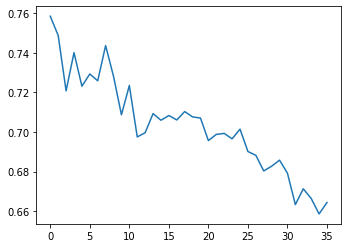

Train, it: 35 loss: 0.66
train loss:  0.6385997533798218


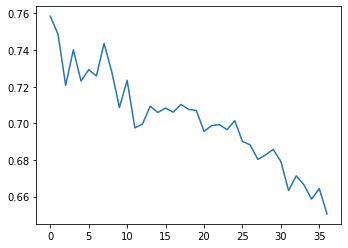

Train, it: 36 loss: 0.65
train loss:  0.6369900107383728


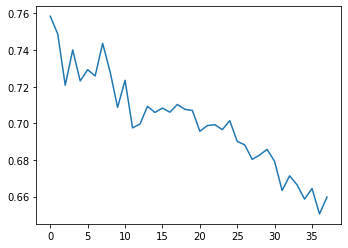

Train, it: 37 loss: 0.66
train loss:  0.6313126087188721


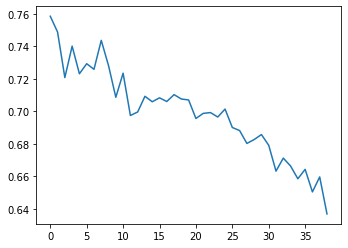

Train, it: 38 loss: 0.64
train loss:  0.6530218124389648


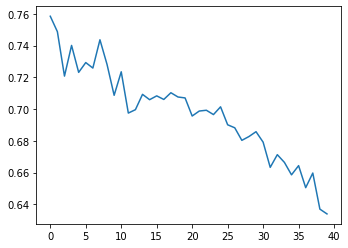

Train, it: 39 loss: 0.63
train loss:  0.6281070709228516


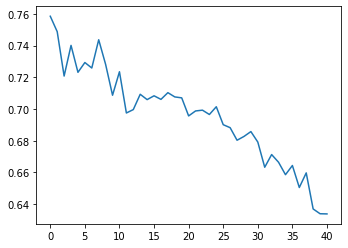

Train, it: 40 loss: 0.63
train loss:  0.6292633414268494


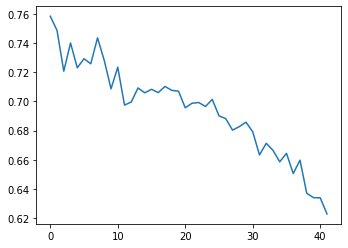

Train, it: 41 loss: 0.62
train loss:  0.6419438123703003


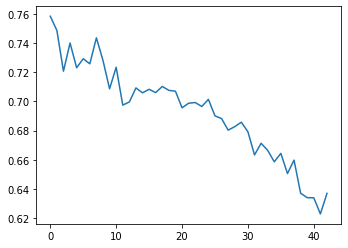

Train, it: 42 loss: 0.64
train loss:  0.6253278255462646


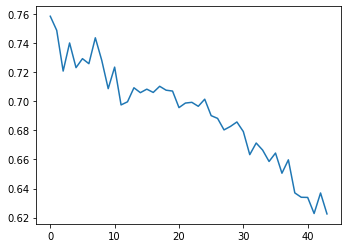

Train, it: 43 loss: 0.62
train loss:  0.6047682762145996


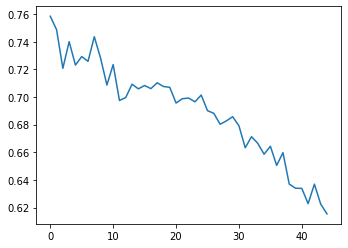

Train, it: 44 loss: 0.62
train loss:  0.5800125002861023


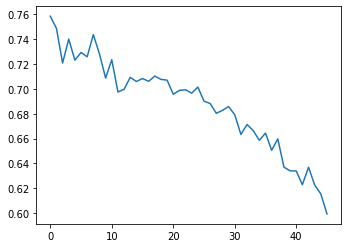

Train, it: 45 loss: 0.60
train loss:  0.5941120982170105


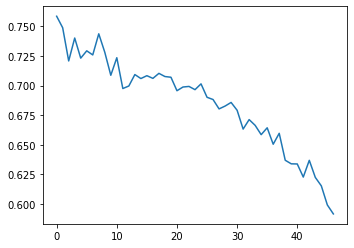

Train, it: 46 loss: 0.59
train loss:  0.5952385663986206


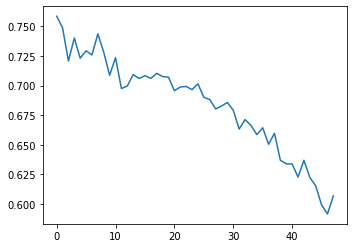

Train, it: 47 loss: 0.61
train loss:  0.6175862550735474


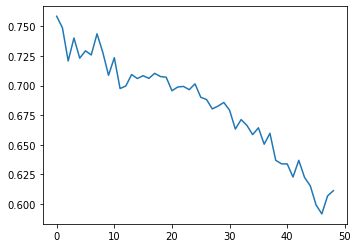

Train, it: 48 loss: 0.61
train loss:  0.5878225564956665


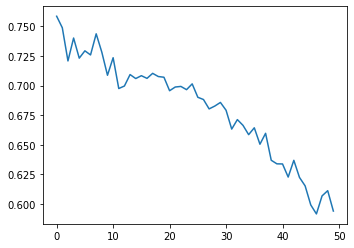

Train, it: 49 loss: 0.59
train loss:  0.5953769683837891


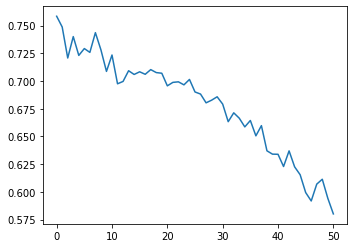

Train, it: 50 loss: 0.58
train loss:  0.6210905909538269


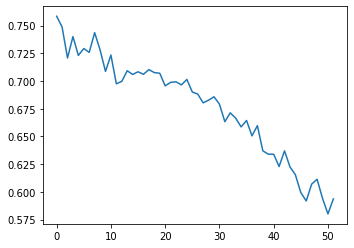

Train, it: 51 loss: 0.59
train loss:  0.5796820521354675


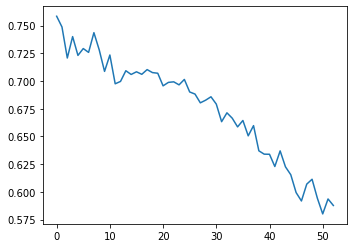

Train, it: 52 loss: 0.59
train loss:  0.570950448513031


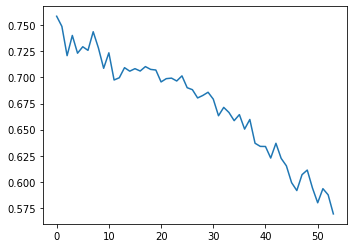

Train, it: 53 loss: 0.57
train loss:  0.5578234791755676


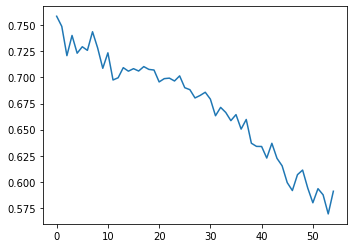

Train, it: 54 loss: 0.59
train loss:  0.557900607585907


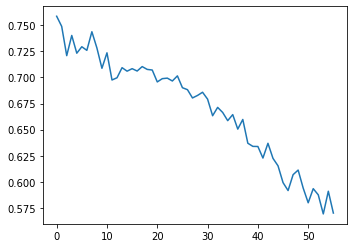

Train, it: 55 loss: 0.57
train loss:  0.5789710283279419


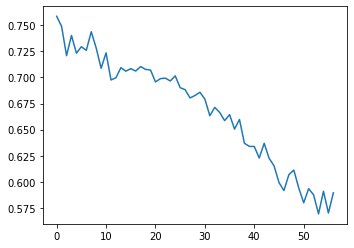

Train, it: 56 loss: 0.59
train loss:  0.5856721997261047


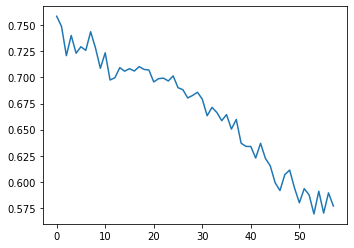

Train, it: 57 loss: 0.58
train loss:  0.5249137282371521


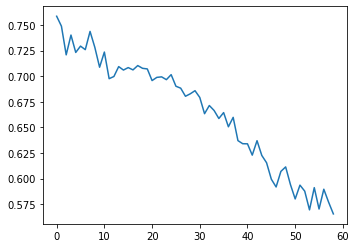

Train, it: 58 loss: 0.57
train loss:  0.5691299438476562


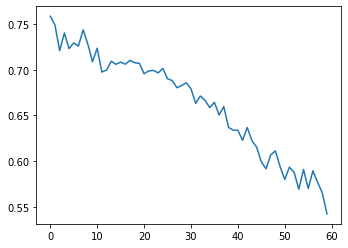

Train, it: 59 loss: 0.54
train loss:  0.5443416237831116


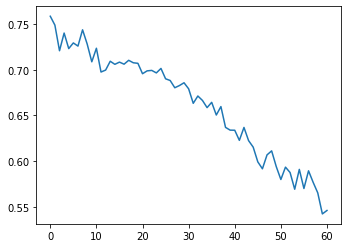

Train, it: 60 loss: 0.55
train loss:  0.5868476629257202


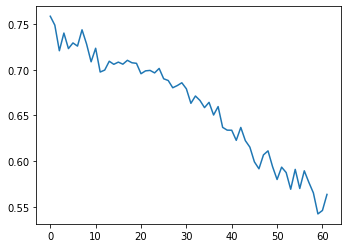

Train, it: 61 loss: 0.56
train loss:  0.5371694564819336


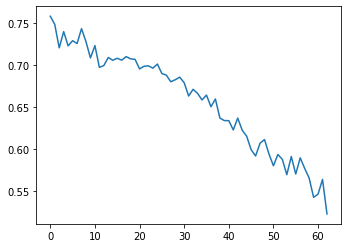

Train, it: 62 loss: 0.52
train loss:  0.5299293994903564


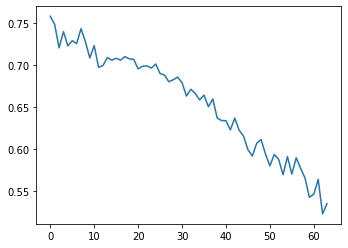

Train, it: 63 loss: 0.53
train loss:  0.511949360370636


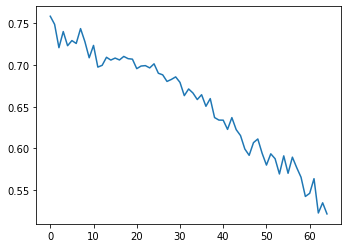

Train, it: 64 loss: 0.52
train loss:  0.5365811586380005


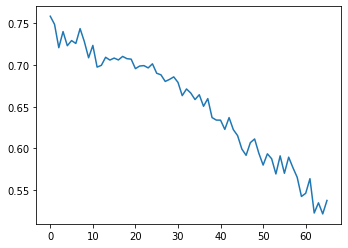

Train, it: 65 loss: 0.54
train loss:  0.49311983585357666


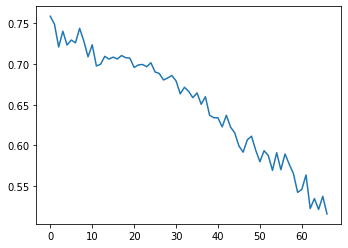

Train, it: 66 loss: 0.52
train loss:  0.5482755899429321


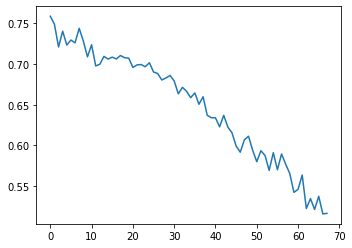

Train, it: 67 loss: 0.52
train loss:  0.4920932650566101


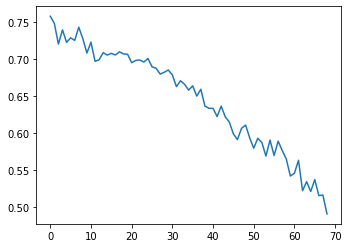

Train, it: 68 loss: 0.49
train loss:  0.46809279918670654


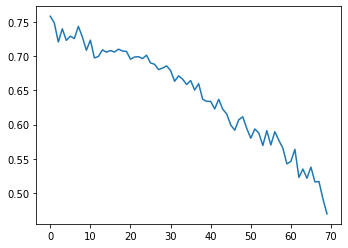

Train, it: 69 loss: 0.47
train loss:  0.4917311370372772


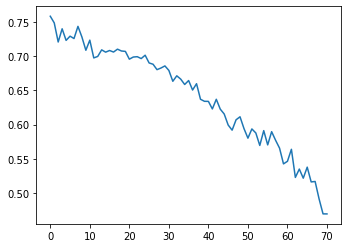

Train, it: 70 loss: 0.47
train loss:  0.4943007230758667


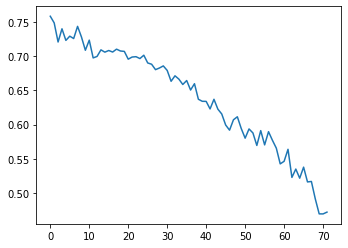

Train, it: 71 loss: 0.47
train loss:  0.44411399960517883


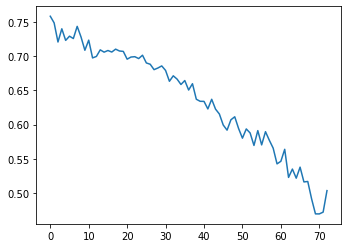

Train, it: 72 loss: 0.50
train loss:  0.5298928618431091


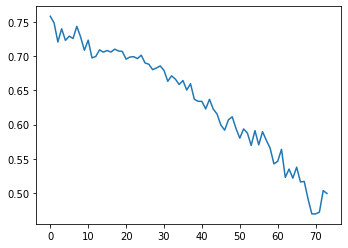

Train, it: 73 loss: 0.50
train loss:  0.4561851918697357


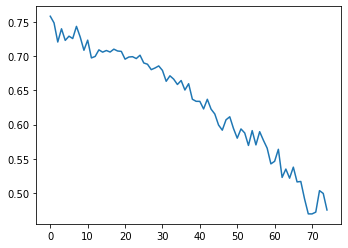

Train, it: 74 loss: 0.47
train loss:  0.4836156368255615


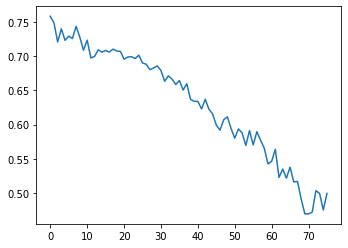

Train, it: 75 loss: 0.50
train loss:  0.4353802502155304


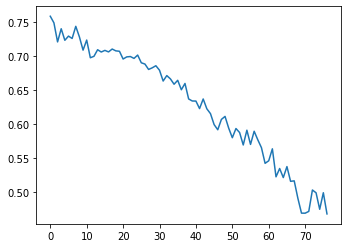

Train, it: 76 loss: 0.47
train loss:  0.47441962361335754


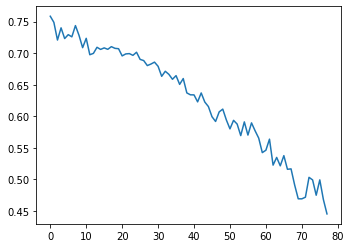

Train, it: 77 loss: 0.45
train loss:  0.43693336844444275


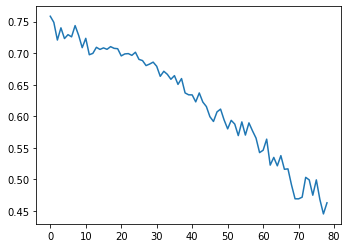

Train, it: 78 loss: 0.46
train loss:  0.47080284357070923


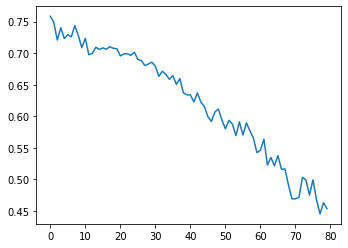

Train, it: 79 loss: 0.45
train loss:  0.3902297914028168


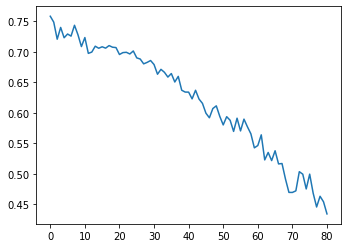

Train, it: 80 loss: 0.43
train loss:  0.4414539337158203


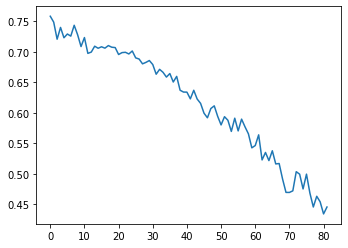

Train, it: 81 loss: 0.45
train loss:  0.47227850556373596


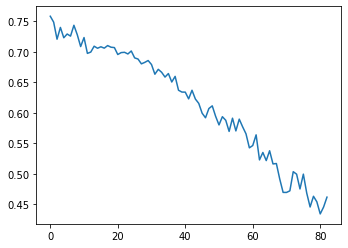

Train, it: 82 loss: 0.46
train loss:  0.475982129573822


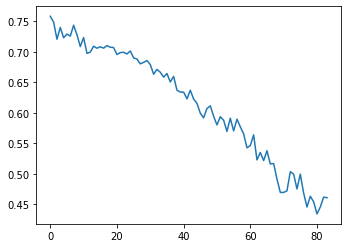

Train, it: 83 loss: 0.46
train loss:  0.46828290820121765


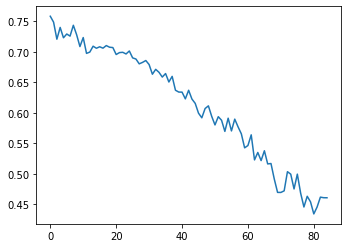

Train, it: 84 loss: 0.46
train loss:  0.43421515822410583


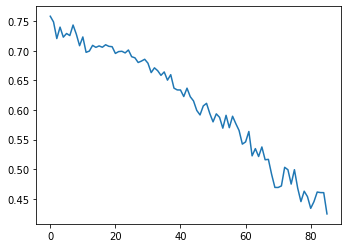

Train, it: 85 loss: 0.42
train loss:  0.4076983630657196


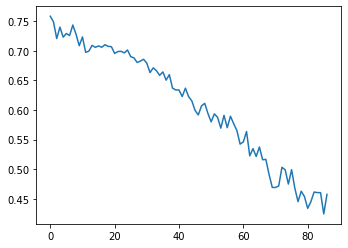

Train, it: 86 loss: 0.46
train loss:  0.4673363268375397


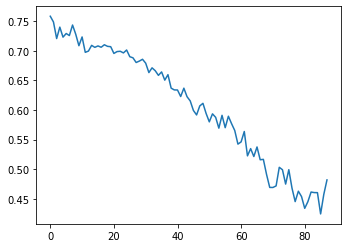

Train, it: 87 loss: 0.48
train loss:  0.4329477548599243


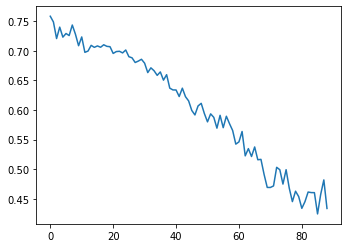

Train, it: 88 loss: 0.43
train loss:  0.4408254027366638


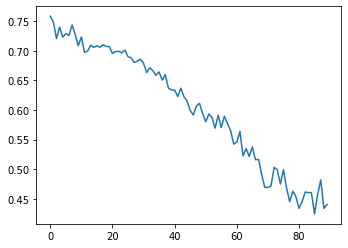

Train, it: 89 loss: 0.44
train loss:  0.47204816341400146


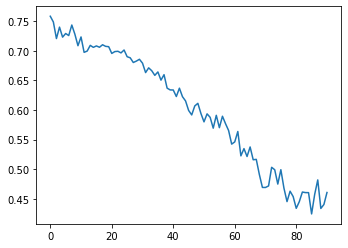

Train, it: 90 loss: 0.46
train loss:  0.45416900515556335


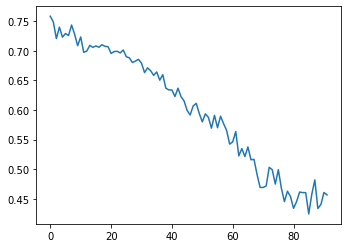

Train, it: 91 loss: 0.46
train loss:  0.5215911269187927


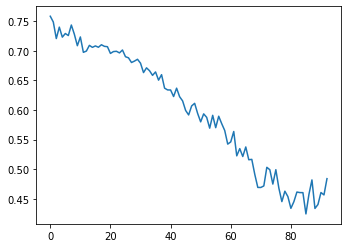

Train, it: 92 loss: 0.48
train loss:  0.5022211074829102


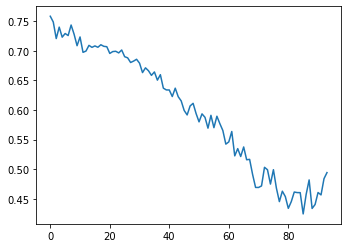

Train, it: 93 loss: 0.49
train loss:  0.4417065978050232


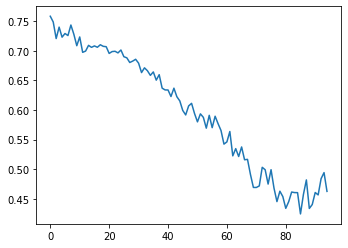

Train, it: 94 loss: 0.46
train loss:  0.4108825623989105


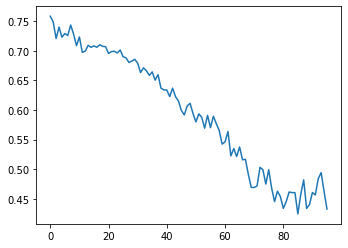

Train, it: 95 loss: 0.43
train loss:  0.4202066659927368


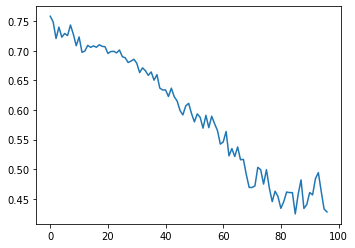

Train, it: 96 loss: 0.43
train loss:  0.42141929268836975


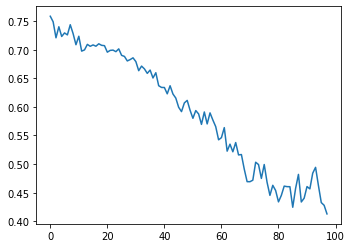

Train, it: 97 loss: 0.41
train loss:  0.4748731851577759


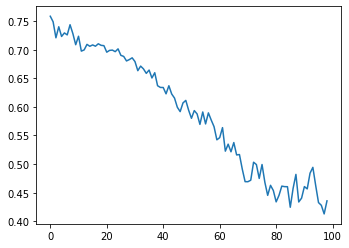

Train, it: 98 loss: 0.44
train loss:  0.45229610800743103


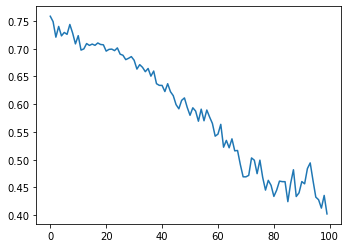

Train, it: 99 loss: 0.40
train loss:  0.3996294438838959


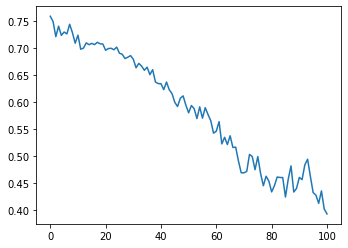

Train, it: 100 loss: 0.39
train loss:  0.40287888050079346


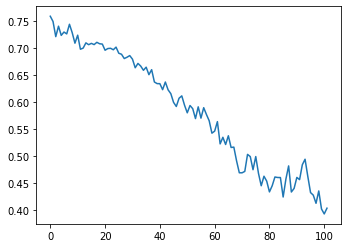

Train, it: 101 loss: 0.40
train loss:  0.38498708605766296


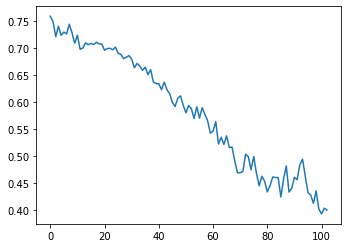

Train, it: 102 loss: 0.40
train loss:  0.4109121859073639


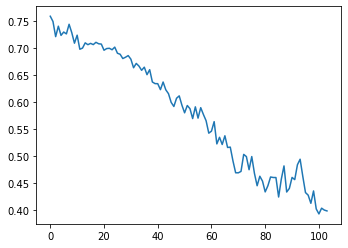

Train, it: 103 loss: 0.40
train loss:  0.4176061153411865


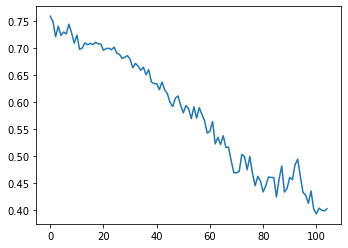

Train, it: 104 loss: 0.40
train loss:  0.386864572763443


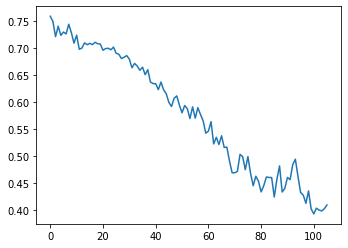

Train, it: 105 loss: 0.41
train loss:  0.42325061559677124


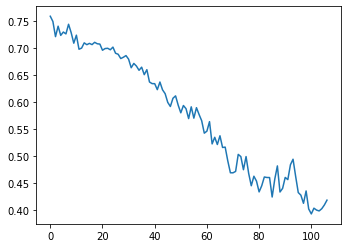

Train, it: 106 loss: 0.42
train loss:  0.4221542179584503


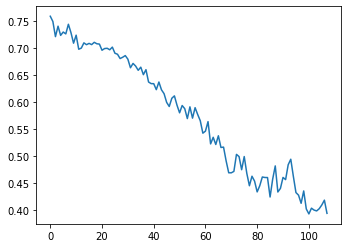

Train, it: 107 loss: 0.39
train loss:  0.3804684281349182


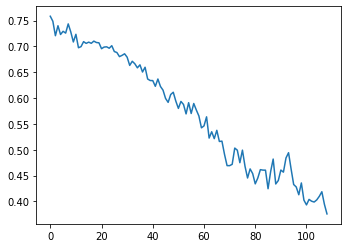

Train, it: 108 loss: 0.38
train loss:  0.3990146517753601


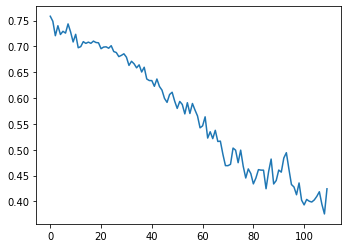

Train, it: 109 loss: 0.42
train loss:  0.45079505443573


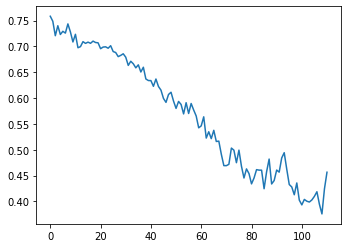

Train, it: 110 loss: 0.46
train loss:  0.472786009311676


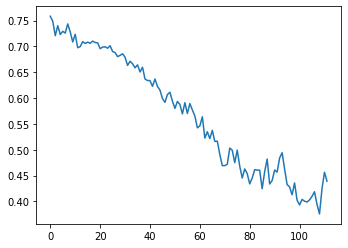

Train, it: 111 loss: 0.44
train loss:  0.42641669511795044


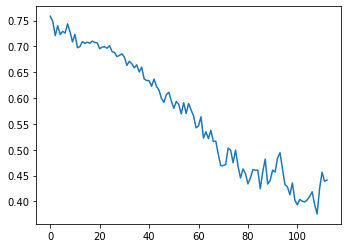

Train, it: 112 loss: 0.44
train loss:  0.3944281339645386


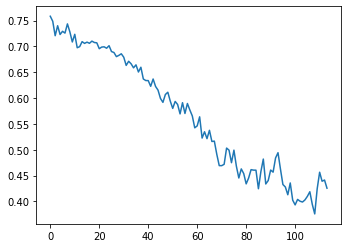

Train, it: 113 loss: 0.43
train loss:  0.41042524576187134


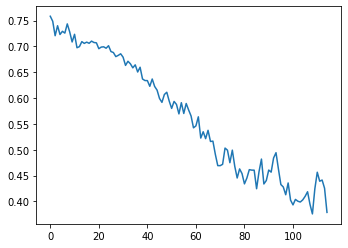

Train, it: 114 loss: 0.38
train loss:  0.42886969447135925


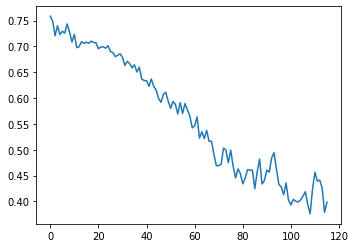

Train, it: 115 loss: 0.40
train loss:  0.38625872135162354


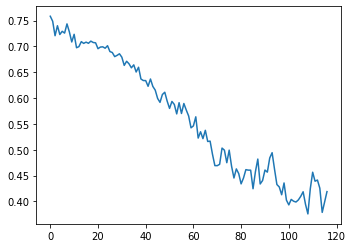

Train, it: 116 loss: 0.42
train loss:  0.3919479548931122


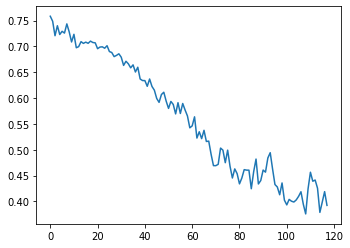

Train, it: 117 loss: 0.39
train loss:  0.3850344717502594


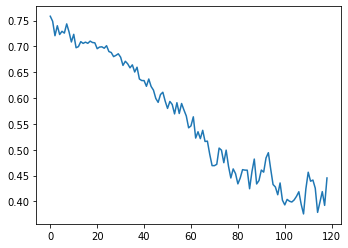

Train, it: 118 loss: 0.45
train loss:  0.4019121527671814


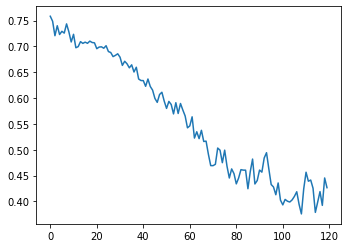

Train, it: 119 loss: 0.43
train loss:  0.408624529838562


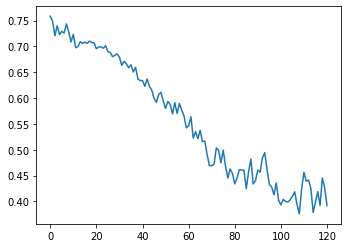

Train, it: 120 loss: 0.39
train loss:  0.38635826110839844


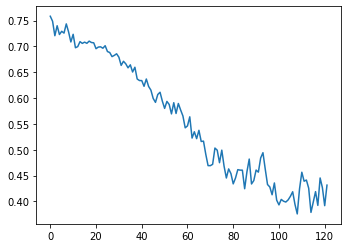

Train, it: 121 loss: 0.43
train loss:  0.4906696677207947


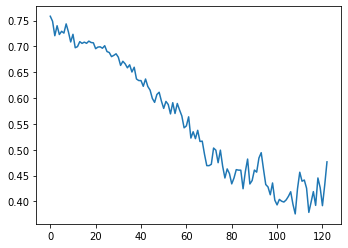

Train, it: 122 loss: 0.48
train loss:  0.3228258192539215


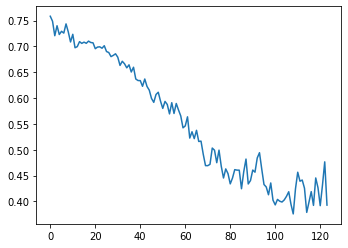

Train, it: 123 loss: 0.39
train loss:  0.3647122085094452


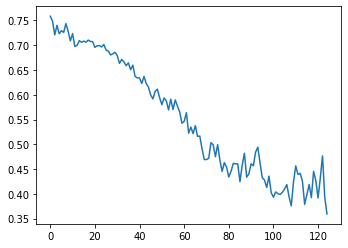

Train, it: 124 loss: 0.36
train loss:  0.3632926046848297


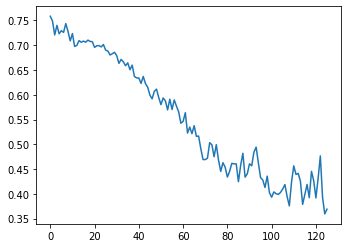

Train, it: 125 loss: 0.37
train loss:  0.3552683889865875


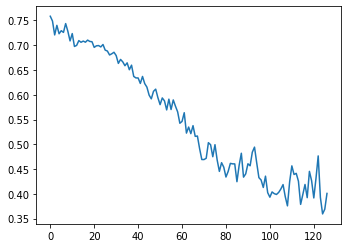

Train, it: 126 loss: 0.40
train loss:  0.42020583152770996


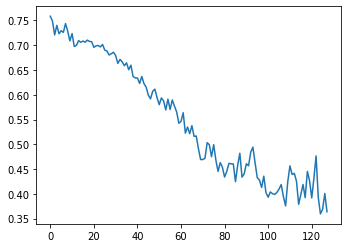

Train, it: 127 loss: 0.36
train loss:  0.35484111309051514


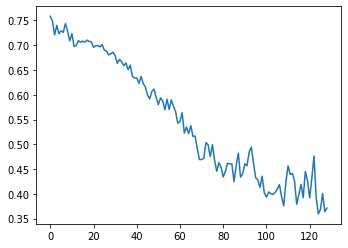

Train, it: 128 loss: 0.37
train loss:  0.4043963551521301


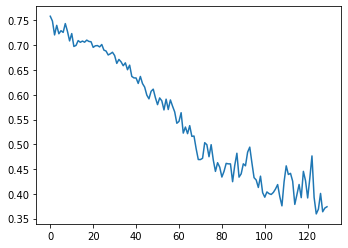

Train, it: 129 loss: 0.37
train loss:  0.36722514033317566


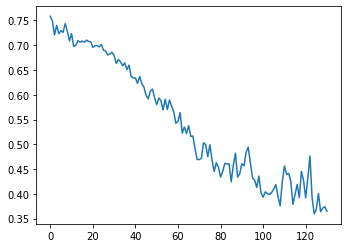

Train, it: 130 loss: 0.36
train loss:  0.3969050645828247


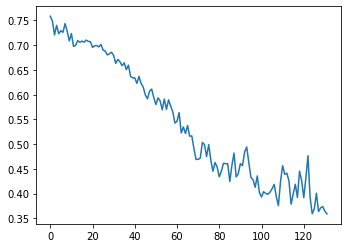

Train, it: 131 loss: 0.36
train loss:  0.33917030692100525


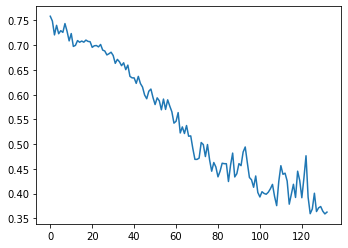

Train, it: 132 loss: 0.36
train loss:  0.2927839159965515


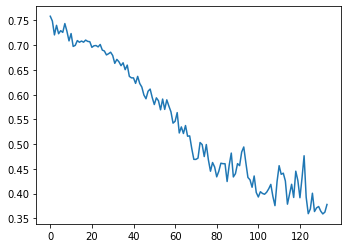

Train, it: 133 loss: 0.38
train loss:  0.3386158049106598


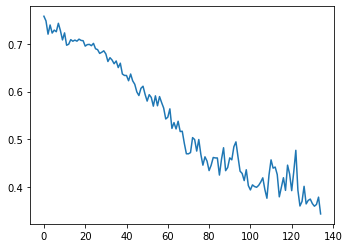

Train, it: 134 loss: 0.34
train loss:  0.42820701003074646


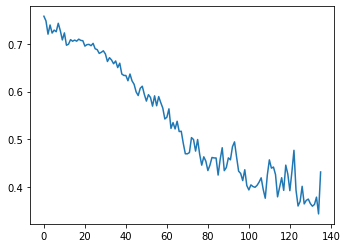

Train, it: 135 loss: 0.43
train loss:  0.36508095264434814


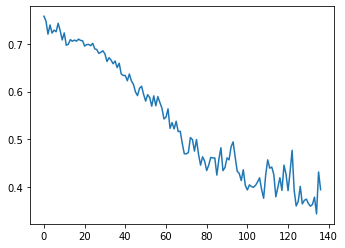

Train, it: 136 loss: 0.39
train loss:  0.41878843307495117


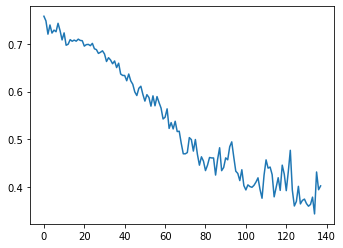

Train, it: 137 loss: 0.40
train loss:  0.3699611723423004


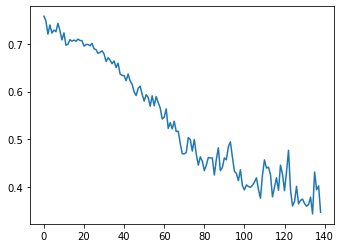

Train, it: 138 loss: 0.35
train loss:  0.29779526591300964


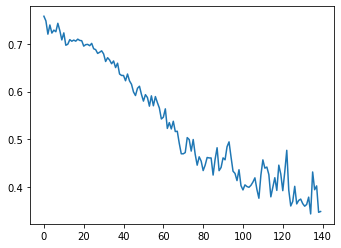

Train, it: 139 loss: 0.35
train loss:  0.45572951436042786


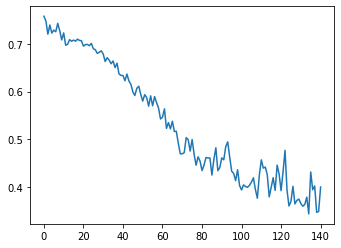

Train, it: 140 loss: 0.40
train loss:  0.43297675251960754


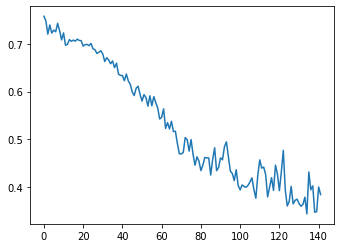

Train, it: 141 loss: 0.38
train loss:  0.39441341161727905


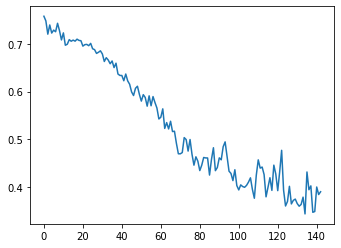

Train, it: 142 loss: 0.39
train loss:  0.35747626423835754


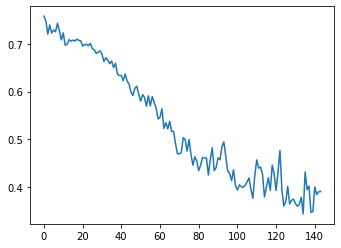

Train, it: 143 loss: 0.39
train loss:  0.371328204870224


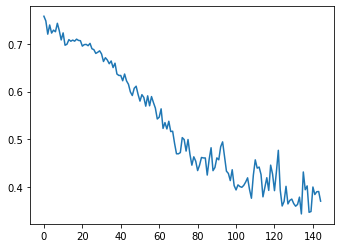

Train, it: 144 loss: 0.37
train loss:  0.35096946358680725


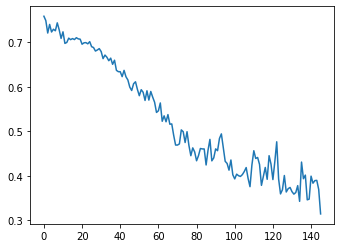

Train, it: 145 loss: 0.31
train loss:  0.3693927228450775


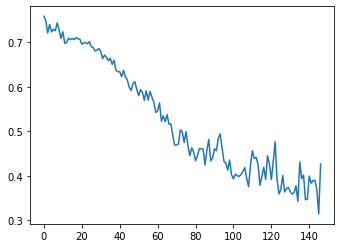

Train, it: 146 loss: 0.43
train loss:  0.3050664961338043


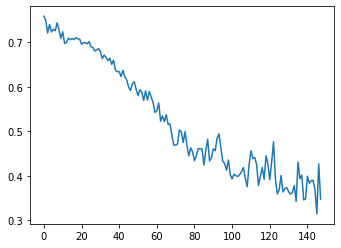

Train, it: 147 loss: 0.35
train loss:  0.35763075947761536


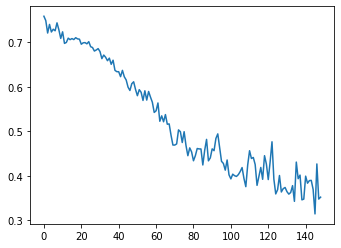

Train, it: 148 loss: 0.35
train loss:  0.3401137590408325


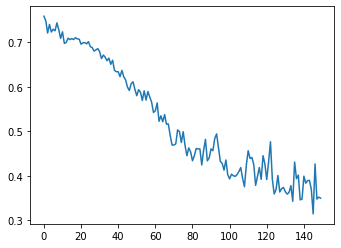

Train, it: 149 loss: 0.35
train loss:  0.452886164188385


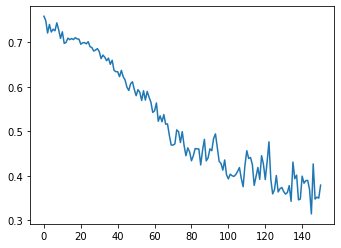

Train, it: 150 loss: 0.38
train loss:  0.39691904187202454


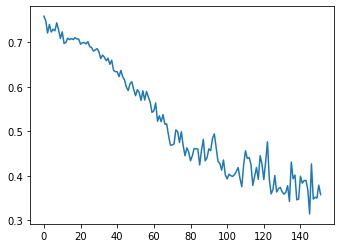

Train, it: 151 loss: 0.36
train loss:  0.3549250364303589


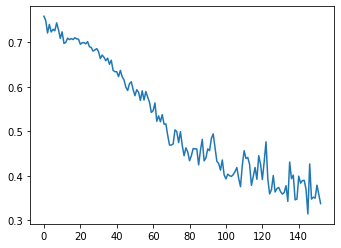

Train, it: 152 loss: 0.34
train loss:  0.37056028842926025


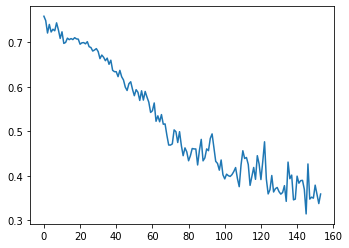

Train, it: 153 loss: 0.36
train loss:  0.32676780223846436


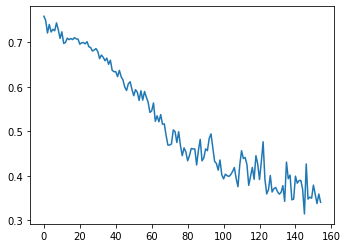

Train, it: 154 loss: 0.34
train loss:  0.36075475811958313


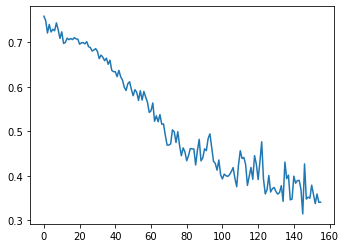

Train, it: 155 loss: 0.34
train loss:  0.3682238757610321


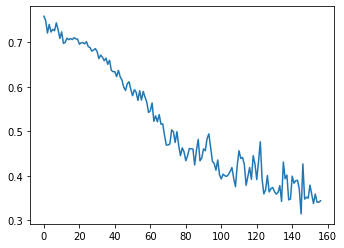

Train, it: 156 loss: 0.34
train loss:  0.37722262740135193


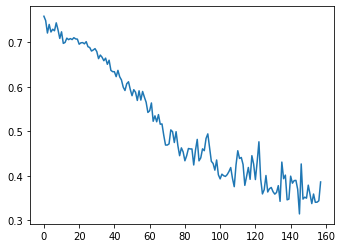

Train, it: 157 loss: 0.39
train loss:  0.33176320791244507


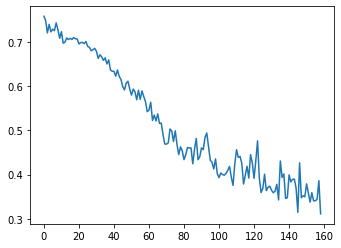

Train, it: 158 loss: 0.31
train loss:  0.3207343518733978


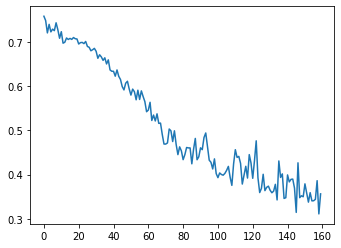

Train, it: 159 loss: 0.36
train loss:  0.33924028277397156


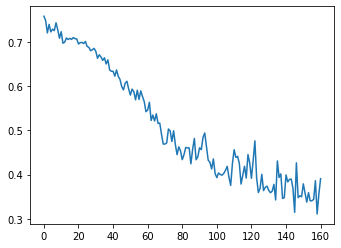

Train, it: 160 loss: 0.39
train loss:  0.3796998858451843


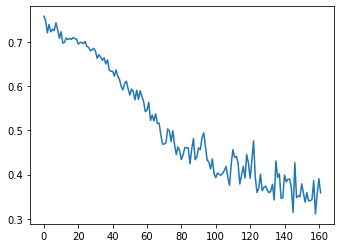

Train, it: 161 loss: 0.36
train loss:  0.39800146222114563


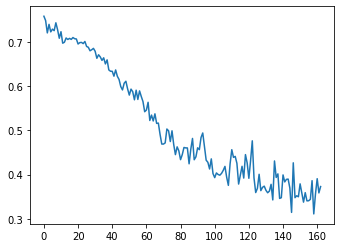

Train, it: 162 loss: 0.37
train loss:  0.35255157947540283


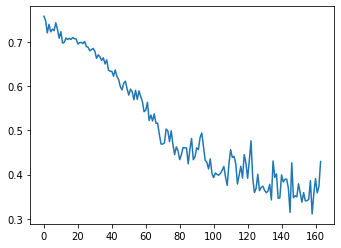

Train, it: 163 loss: 0.43
train loss:  0.3268131613731384


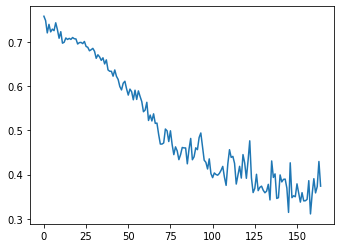

Train, it: 164 loss: 0.37
train loss:  0.40067365765571594


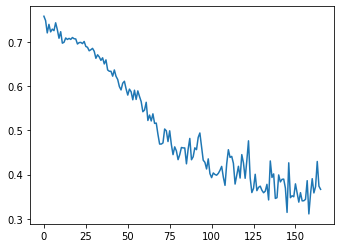

Train, it: 165 loss: 0.37
train loss:  0.3493092656135559


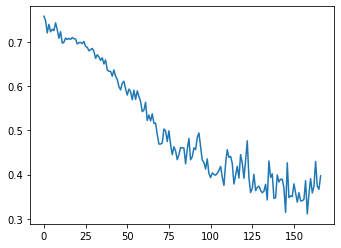

Train, it: 166 loss: 0.40
train loss:  0.30996960401535034


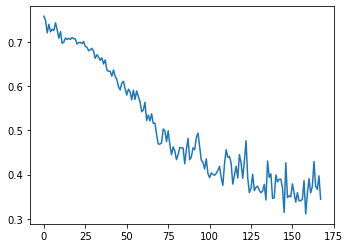

Train, it: 167 loss: 0.34
train loss:  0.3246864676475525


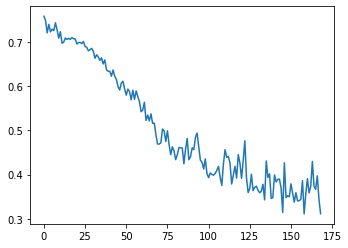

Train, it: 168 loss: 0.31
train loss:  0.37711101770401


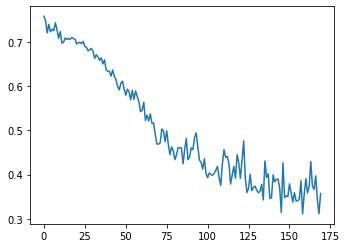

Train, it: 169 loss: 0.36
train loss:  0.37522628903388977


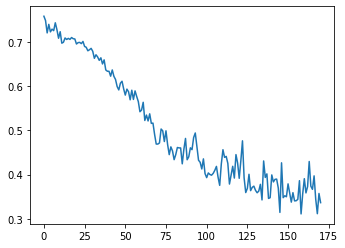

Train, it: 170 loss: 0.34
train loss:  0.33284780383110046


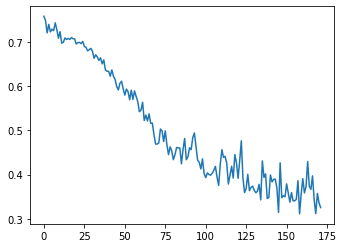

Train, it: 171 loss: 0.33
train loss:  0.312956303358078


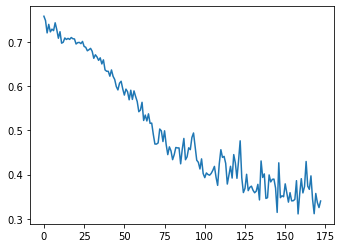

Train, it: 172 loss: 0.34
train loss:  0.3431793451309204


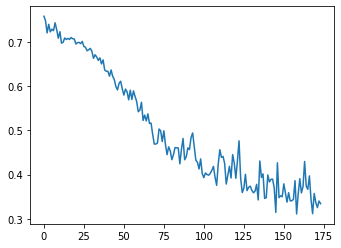

Train, it: 173 loss: 0.33
train loss:  0.4010932147502899


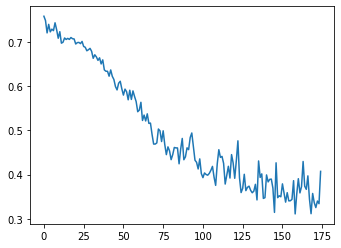

Train, it: 174 loss: 0.41
train loss:  0.39444658160209656


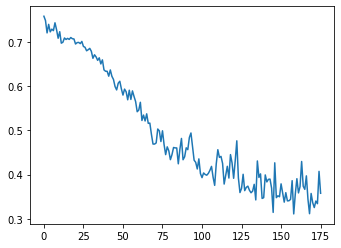

Train, it: 175 loss: 0.36
train loss:  0.39025408029556274


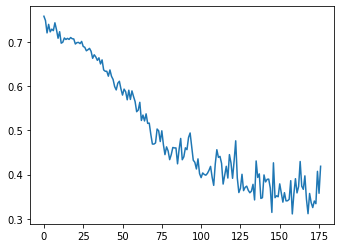

Train, it: 176 loss: 0.42
train loss:  0.32343608140945435


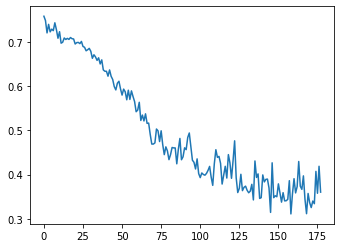

Train, it: 177 loss: 0.36
train loss:  0.4291319251060486


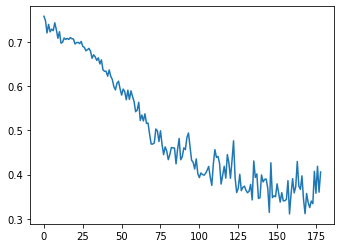

Train, it: 178 loss: 0.41
train loss:  0.3915639817714691


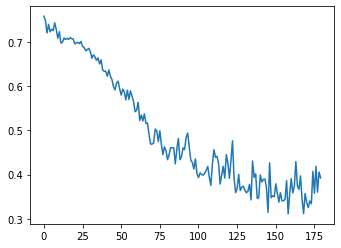

Train, it: 179 loss: 0.39
train loss:  0.3083268702030182


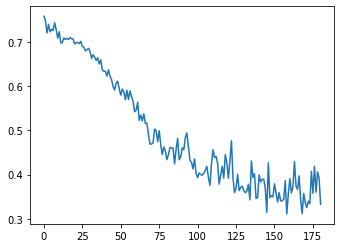

Train, it: 180 loss: 0.33
train loss:  0.30811914801597595


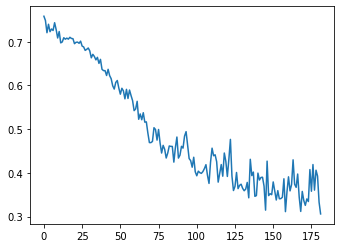

Train, it: 181 loss: 0.31
train loss:  0.3792831003665924


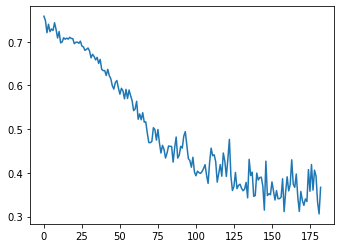

Train, it: 182 loss: 0.37
train loss:  0.2819366157054901


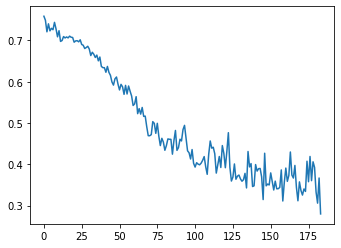

Train, it: 183 loss: 0.28
train loss:  0.31804123520851135


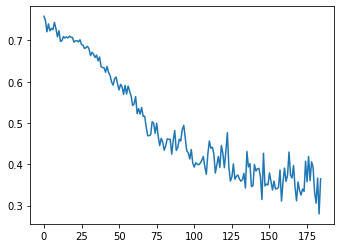

Train, it: 184 loss: 0.36
train loss:  0.3836720883846283


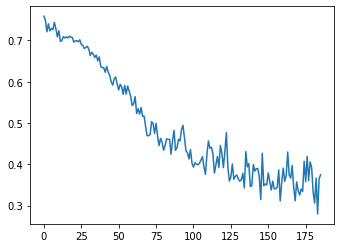

Train, it: 185 loss: 0.37
train loss:  0.31257978081703186


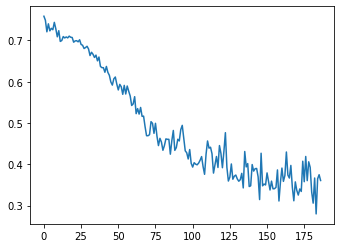

Train, it: 186 loss: 0.36
train loss:  0.3256053030490875


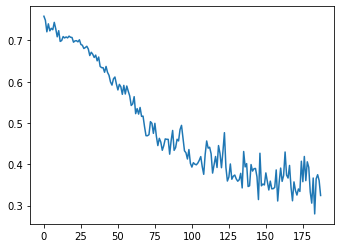

Train, it: 187 loss: 0.32
train loss:  0.3287898898124695


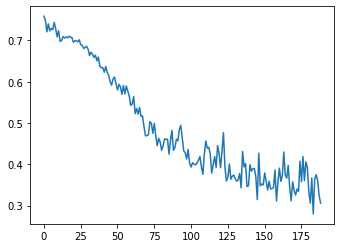

Train, it: 188 loss: 0.31
train loss:  0.312086820602417


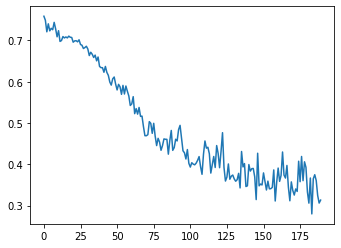

Train, it: 189 loss: 0.31
train loss:  0.3191477954387665


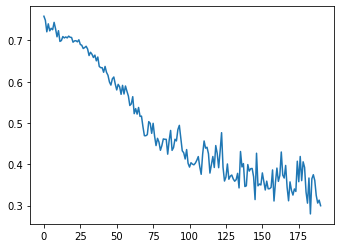

Train, it: 190 loss: 0.30
train loss:  0.27255696058273315


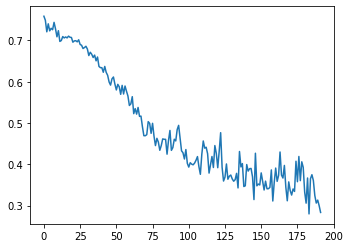

Train, it: 191 loss: 0.28
train loss:  0.28162050247192383


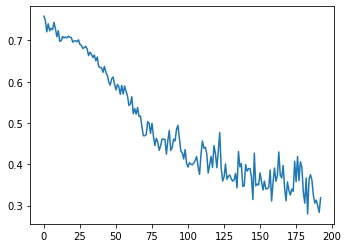

Train, it: 192 loss: 0.32
train loss:  0.30016568303108215


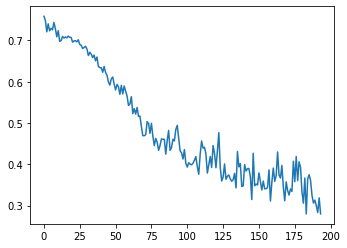

Train, it: 193 loss: 0.28
train loss:  0.28385165333747864


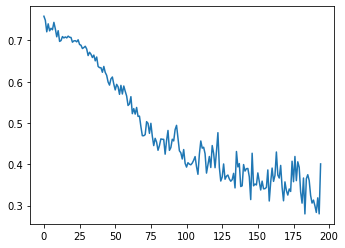

Train, it: 194 loss: 0.40
train loss:  0.2677094340324402


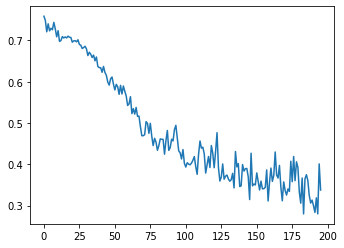

Train, it: 195 loss: 0.34
train loss:  0.30573201179504395


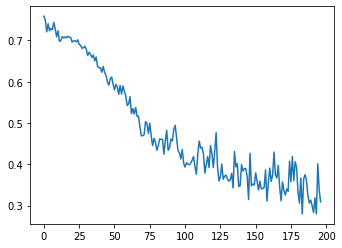

Train, it: 196 loss: 0.31
train loss:  0.3192150294780731


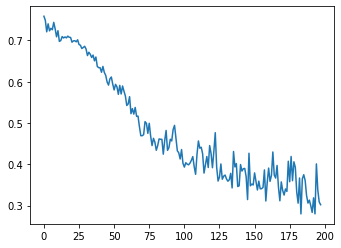

Train, it: 197 loss: 0.30
train loss:  0.26786184310913086


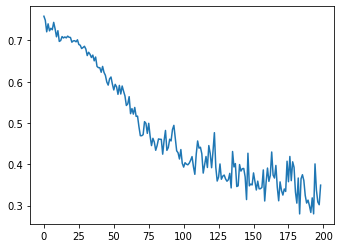

Train, it: 198 loss: 0.35
train loss:  0.3137495219707489


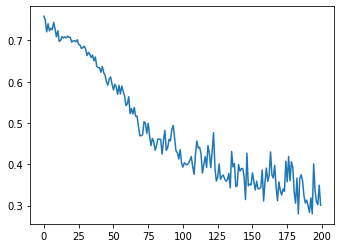

Train, it: 199 loss: 0.30
train loss:  0.3804055452346802


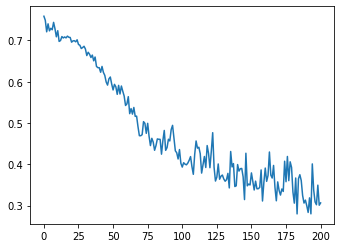

Train, it: 200 loss: 0.31
train loss:  0.2787107229232788


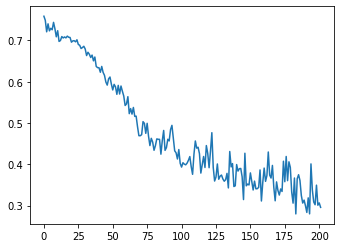

Train, it: 201 loss: 0.30
train loss:  0.3060562014579773


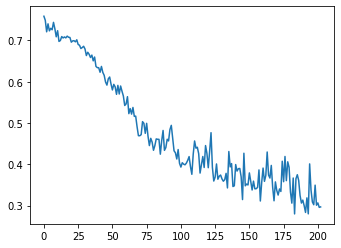

Train, it: 202 loss: 0.30
train loss:  0.3655255138874054


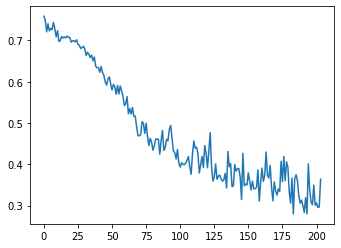

Train, it: 203 loss: 0.36
train loss:  0.3349650800228119


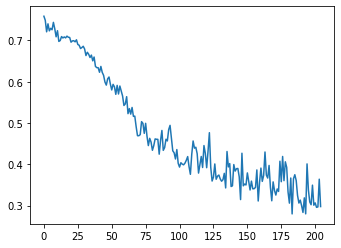

Train, it: 204 loss: 0.30
train loss:  0.31534555554389954


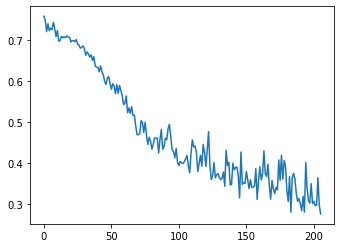

Train, it: 205 loss: 0.28
train loss:  0.28447431325912476


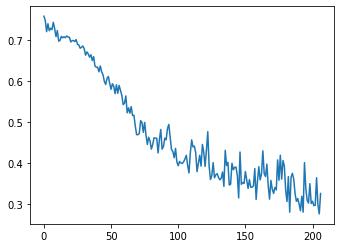

Train, it: 206 loss: 0.33
train loss:  0.24962295591831207


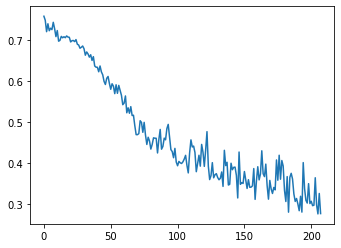

Train, it: 207 loss: 0.28
train loss:  0.37195226550102234


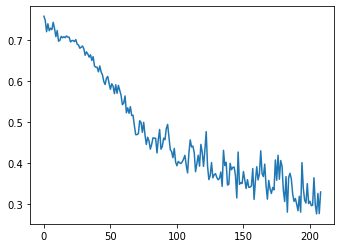

Train, it: 208 loss: 0.33
train loss:  0.2766723334789276


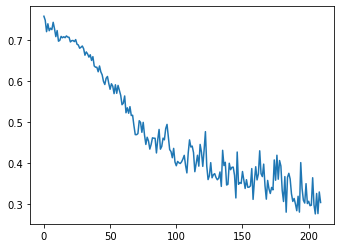

Train, it: 209 loss: 0.30
train loss:  0.27884504199028015


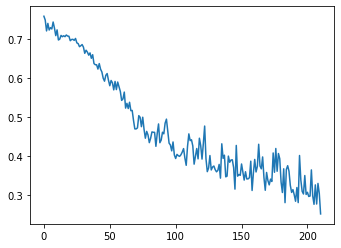

Train, it: 210 loss: 0.25
train loss:  0.2521754503250122


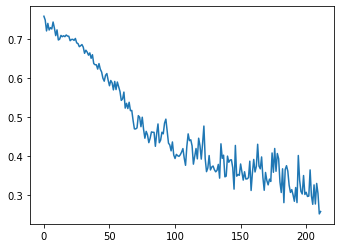

Train, it: 211 loss: 0.26
train loss:  0.33423712849617004


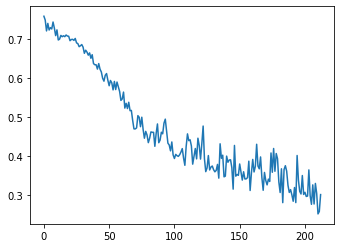

Train, it: 212 loss: 0.30
train loss:  0.23967061936855316


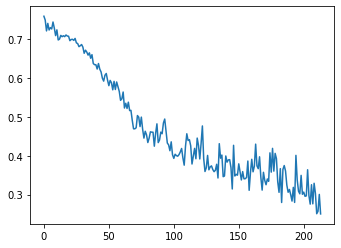

Train, it: 213 loss: 0.25
train loss:  0.2992691993713379


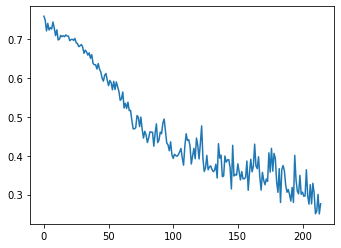

Train, it: 214 loss: 0.28
train loss:  0.310009241104126


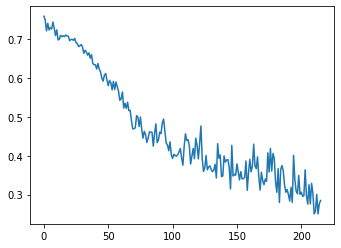

Train, it: 215 loss: 0.29
train loss:  0.31602463126182556


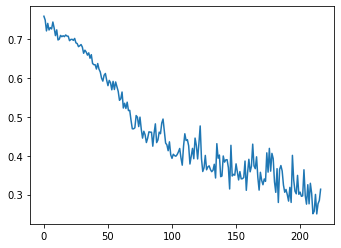

Train, it: 216 loss: 0.31
train loss:  0.28681114315986633


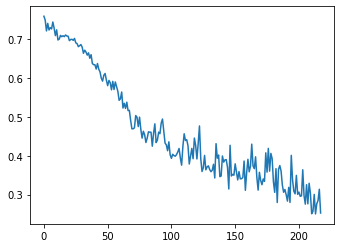

Train, it: 217 loss: 0.25
train loss:  0.2956123352050781


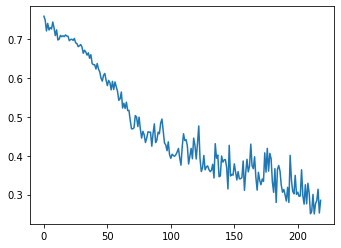

Train, it: 218 loss: 0.29
train loss:  0.2565833330154419


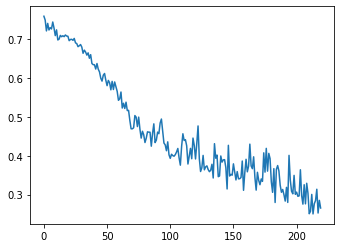

Train, it: 219 loss: 0.27
train loss:  0.2881574332714081


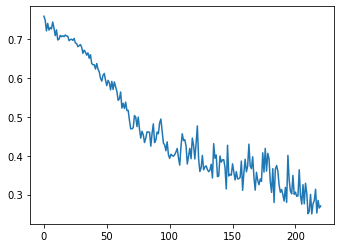

Train, it: 220 loss: 0.27
train loss:  0.24840384721755981


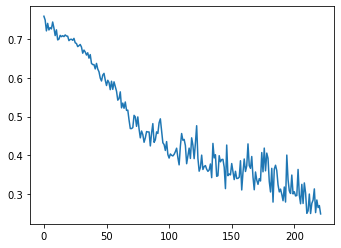

Train, it: 221 loss: 0.25
train loss:  0.30391672253608704


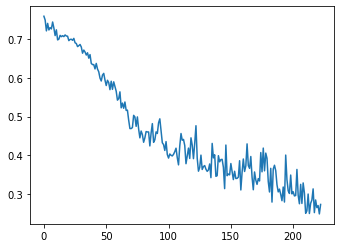

Train, it: 222 loss: 0.27
train loss:  0.3068348169326782


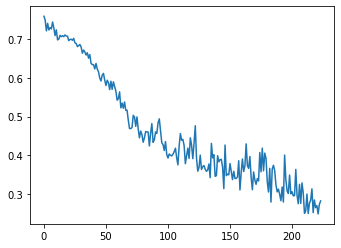

Train, it: 223 loss: 0.28
train loss:  0.2910826504230499


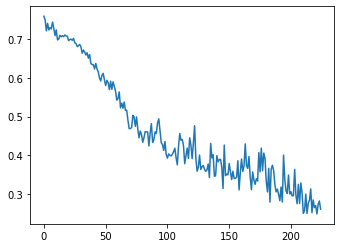

Train, it: 224 loss: 0.26
train loss:  0.24722544848918915


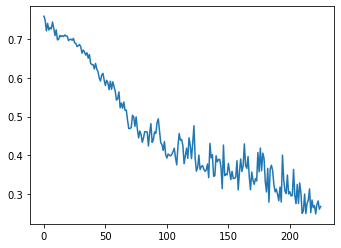

Train, it: 225 loss: 0.27
train loss:  0.24431230127811432


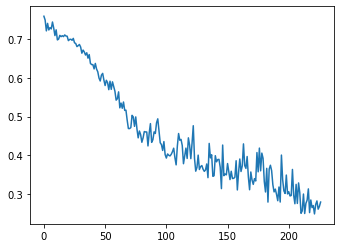

Train, it: 226 loss: 0.28
train loss:  0.25808700919151306


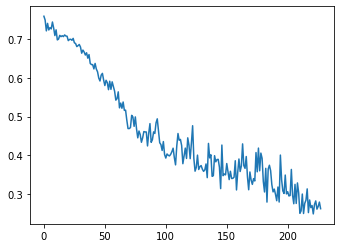

Train, it: 227 loss: 0.26
train loss:  0.3013206720352173


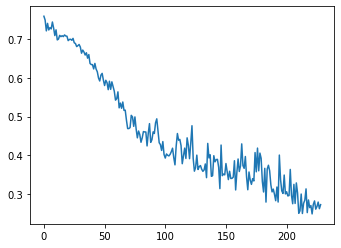

Train, it: 228 loss: 0.27
train loss:  0.319961816072464


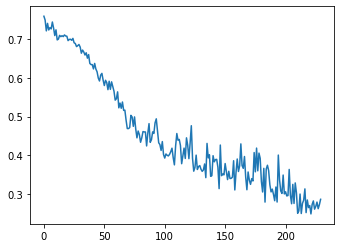

Train, it: 229 loss: 0.29
train loss:  0.2189156413078308


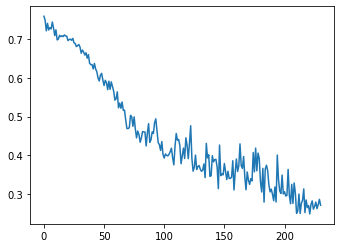

Train, it: 230 loss: 0.27
train loss:  0.30942127108573914


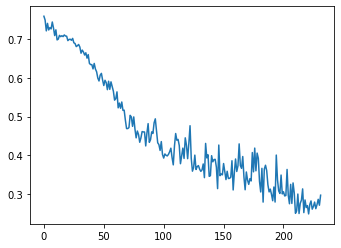

Train, it: 231 loss: 0.30
train loss:  0.2818267345428467


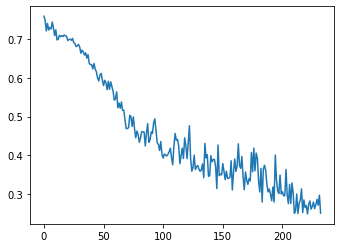

Train, it: 232 loss: 0.25
train loss:  0.2743901014328003


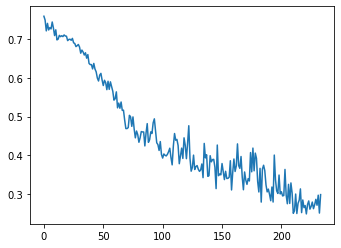

Train, it: 233 loss: 0.30
train loss:  0.3010134994983673


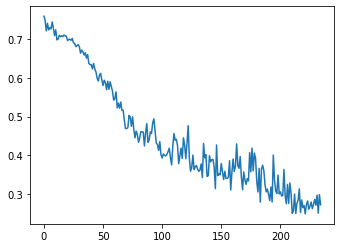

Train, it: 234 loss: 0.27
train loss:  0.27086588740348816


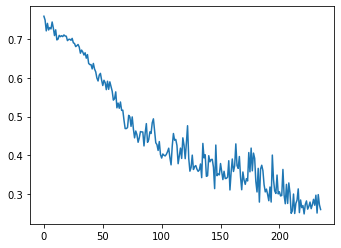

Train, it: 235 loss: 0.26
train loss:  0.23393620550632477


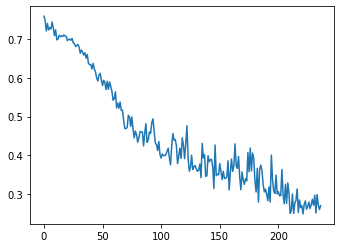

Train, it: 236 loss: 0.27
train loss:  0.29456907510757446


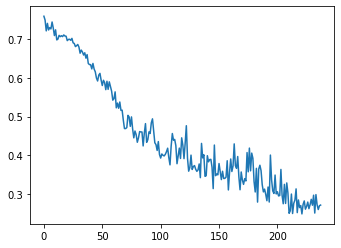

Train, it: 237 loss: 0.27
train loss:  0.25061720609664917


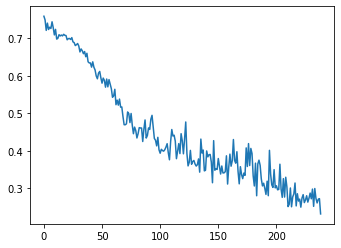

Train, it: 238 loss: 0.23
train loss:  0.23446616530418396


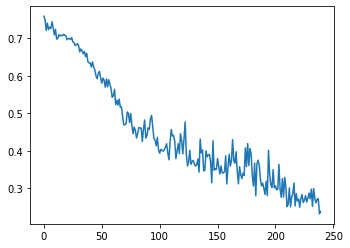

Train, it: 239 loss: 0.24
train loss:  0.23215535283088684


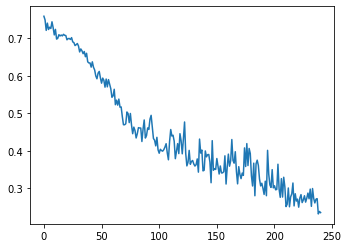

Train, it: 240 loss: 0.23
train loss:  0.22760061919689178


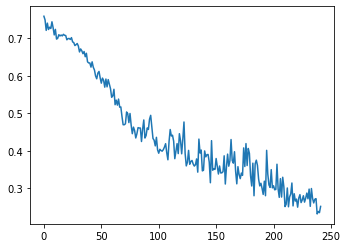

Train, it: 241 loss: 0.25
train loss:  0.2570536434650421


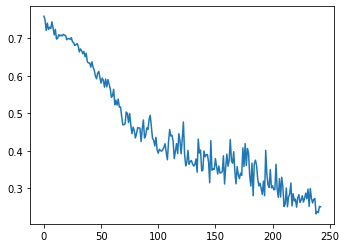

Train, it: 242 loss: 0.25
train loss:  0.2750455141067505


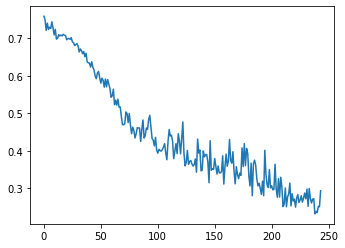

Train, it: 243 loss: 0.29
train loss:  0.2538350522518158


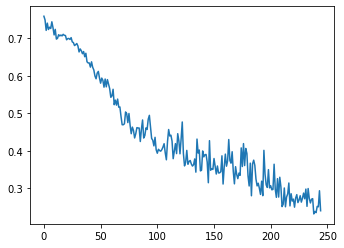

Train, it: 244 loss: 0.24
train loss:  0.27198082208633423


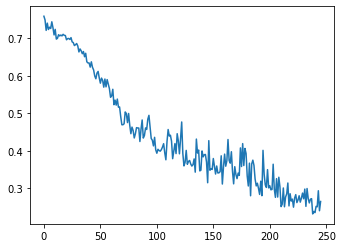

Train, it: 245 loss: 0.26
train loss:  0.2690557539463043


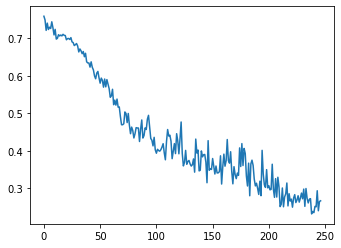

Train, it: 246 loss: 0.27
train loss:  0.2949439287185669


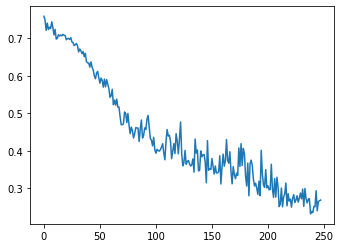

Train, it: 247 loss: 0.27
train loss:  0.25751009583473206


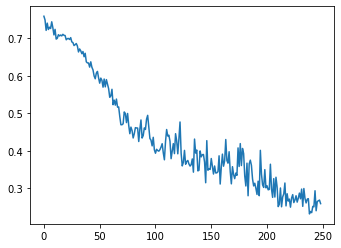

Train, it: 248 loss: 0.26
train loss:  0.23040126264095306


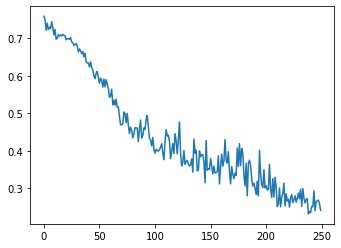

Train, it: 249 loss: 0.24
train loss:  0.2975981831550598


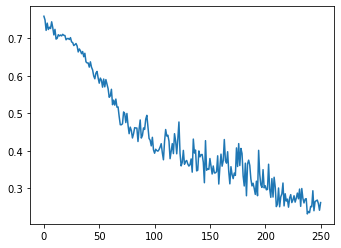

Train, it: 250 loss: 0.26
train loss:  0.2553144693374634


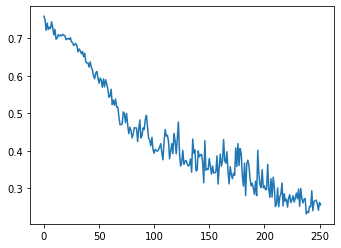

Train, it: 251 loss: 0.26
train loss:  0.30725058913230896


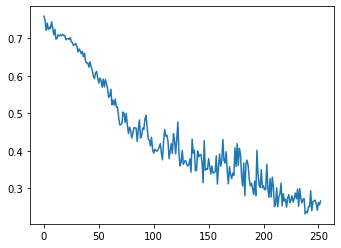

Train, it: 252 loss: 0.27
train loss:  0.32776346802711487


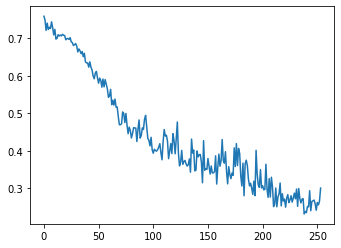

Train, it: 253 loss: 0.30
train loss:  0.2907126545906067


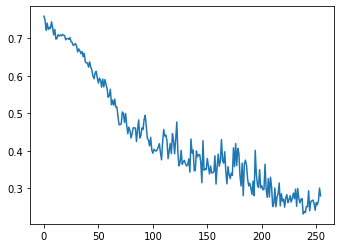

Train, it: 254 loss: 0.28
train loss:  0.27693337202072144


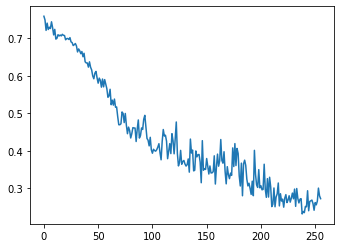

Train, it: 255 loss: 0.27
train loss:  0.3043903708457947


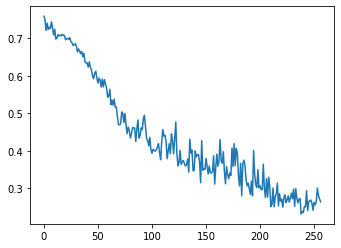

Train, it: 256 loss: 0.26
train loss:  0.2605792284011841


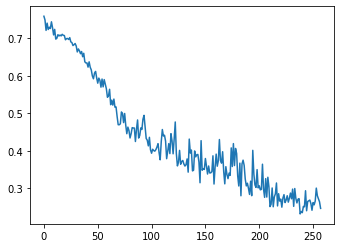

Train, it: 257 loss: 0.25
train loss:  0.24589292705059052


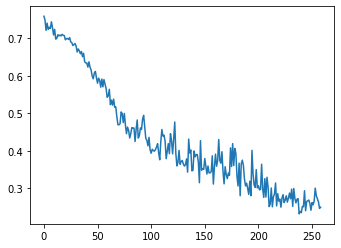

Train, it: 258 loss: 0.25
train loss:  0.27652508020401


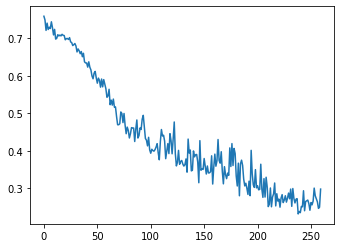

Train, it: 259 loss: 0.30
train loss:  0.26195377111434937


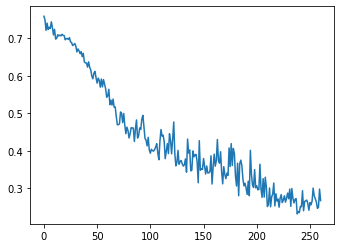

Train, it: 260 loss: 0.27
train loss:  0.24390414357185364


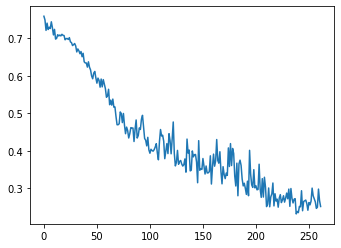

Train, it: 261 loss: 0.25
train loss:  0.37550604343414307


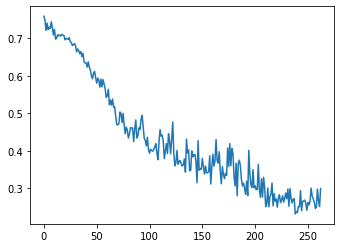

Train, it: 262 loss: 0.30
train loss:  0.2279071807861328


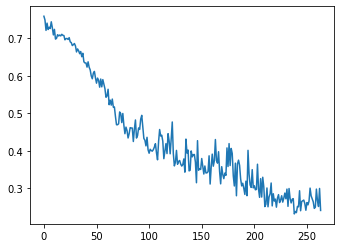

Train, it: 263 loss: 0.24
train loss:  0.3099925220012665


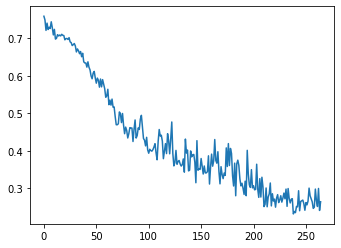

Train, it: 264 loss: 0.26
train loss:  0.3080890476703644


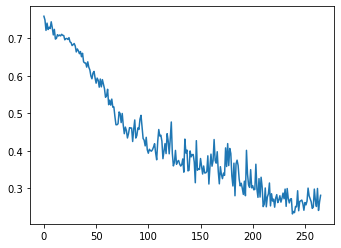

Train, it: 265 loss: 0.28
train loss:  0.288684219121933


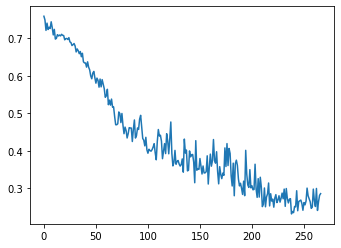

Train, it: 266 loss: 0.29
train loss:  0.25447484850883484


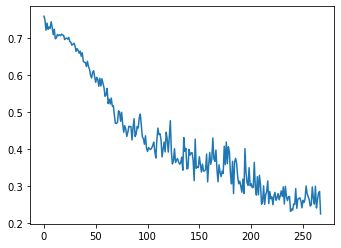

Train, it: 267 loss: 0.22
train loss:  0.23999057710170746


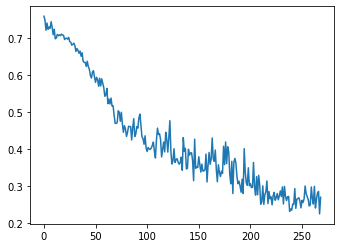

Train, it: 268 loss: 0.27
train loss:  0.24540019035339355


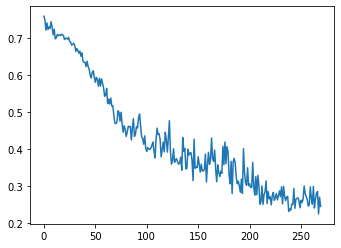

Train, it: 269 loss: 0.24
train loss:  0.22059208154678345


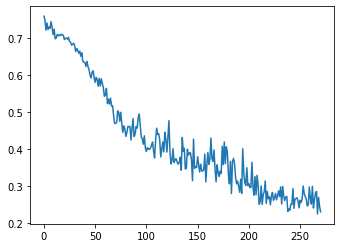

Train, it: 270 loss: 0.23
train loss:  0.26748567819595337


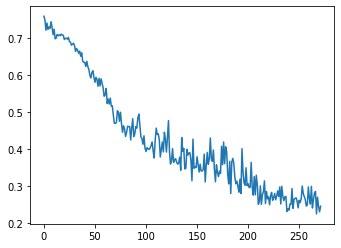

Train, it: 271 loss: 0.25
train loss:  0.2571624219417572


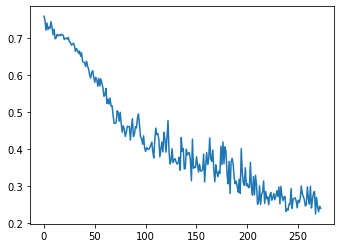

Train, it: 272 loss: 0.24
train loss:  0.26789408922195435


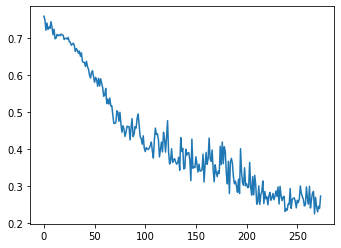

Train, it: 273 loss: 0.27
train loss:  0.26620376110076904


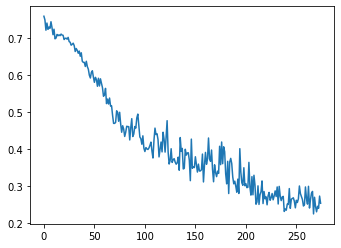

Train, it: 274 loss: 0.25
train loss:  0.23760055005550385


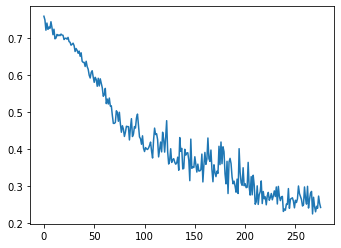

Train, it: 275 loss: 0.24
train loss:  0.25360435247421265


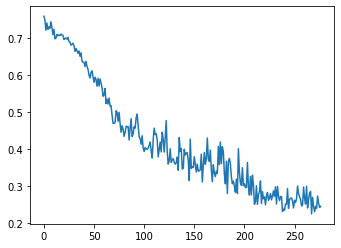

Train, it: 276 loss: 0.25
train loss:  0.28087764978408813


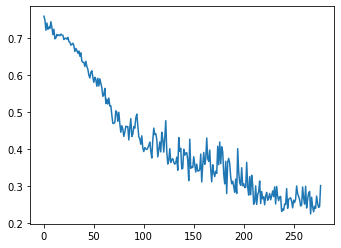

Train, it: 277 loss: 0.30
train loss:  0.2718207836151123


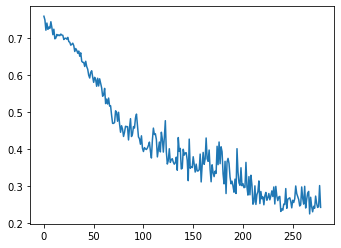

Train, it: 278 loss: 0.24
train loss:  0.2903720736503601


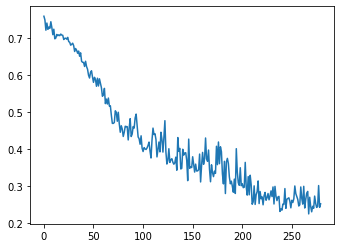

Train, it: 279 loss: 0.25
train loss:  0.23964309692382812


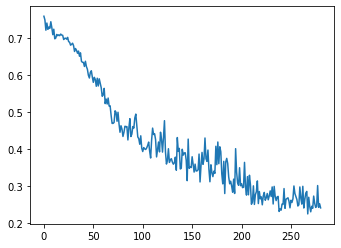

Train, it: 280 loss: 0.24
train loss:  0.23475101590156555


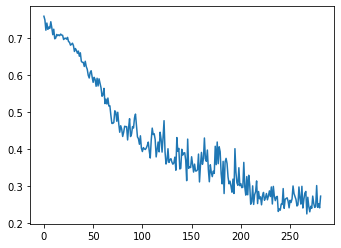

Train, it: 281 loss: 0.27
train loss:  0.21278394758701324


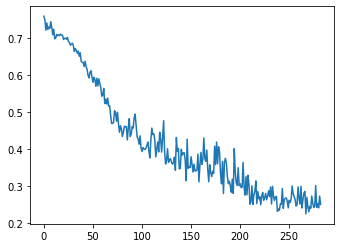

Train, it: 282 loss: 0.25
train loss:  0.24450962245464325


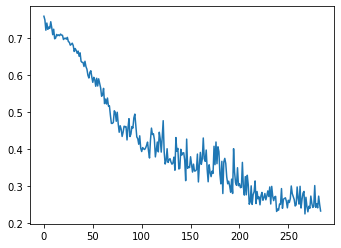

Train, it: 283 loss: 0.23
train loss:  0.22180408239364624


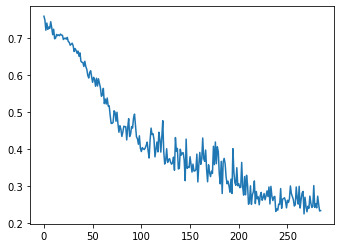

Train, it: 284 loss: 0.23
train loss:  0.2571141719818115


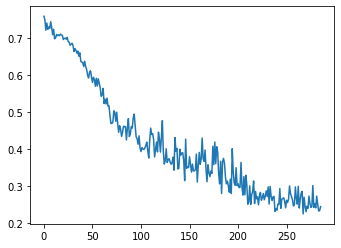

Train, it: 285 loss: 0.24
train loss:  0.23955810070037842


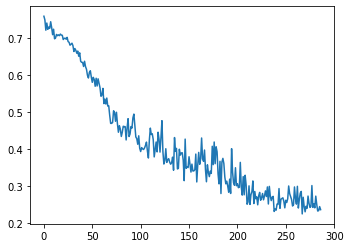

Train, it: 286 loss: 0.24
train loss:  0.2194298505783081


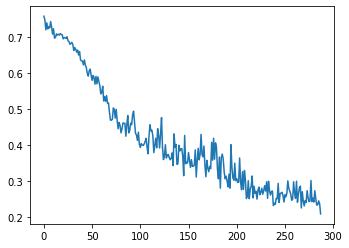

Train, it: 287 loss: 0.21
train loss:  0.26083502173423767


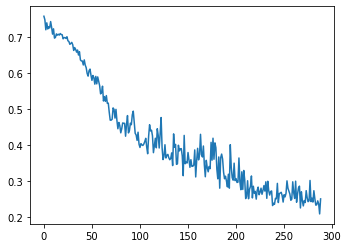

Train, it: 288 loss: 0.25
train loss:  0.21442966163158417


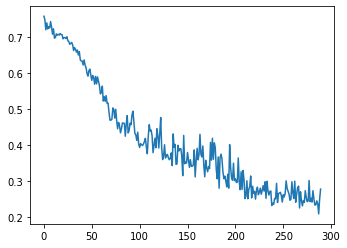

Train, it: 289 loss: 0.28
train loss:  0.25317877531051636


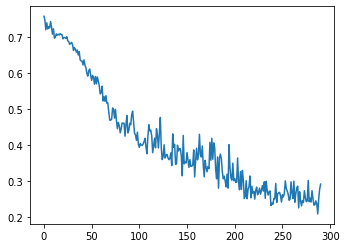

Train, it: 290 loss: 0.29
train loss:  0.30098623037338257


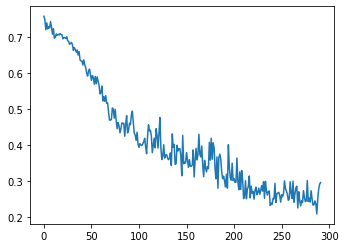

Train, it: 291 loss: 0.30
train loss:  0.22871753573417664


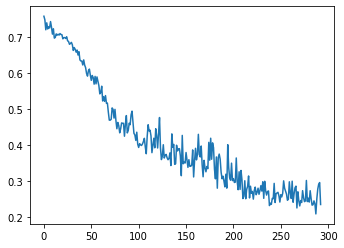

Train, it: 292 loss: 0.23
train loss:  0.24549056589603424


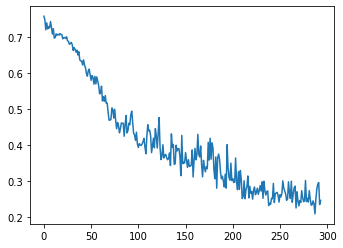

Train, it: 293 loss: 0.25
train loss:  0.2693232595920563


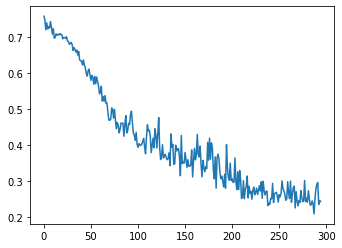

Train, it: 294 loss: 0.24
train loss:  0.23196975886821747


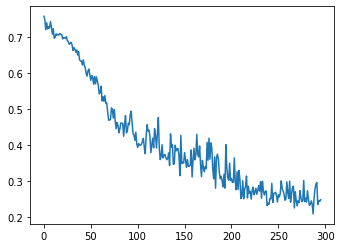

Train, it: 295 loss: 0.25
train loss:  0.2614622414112091


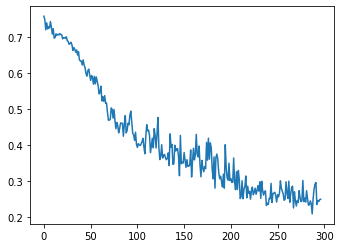

Train, it: 296 loss: 0.25
train loss:  0.2170066237449646


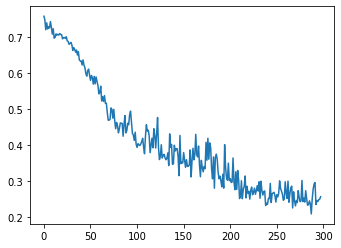

Train, it: 297 loss: 0.26
train loss:  0.20843935012817383


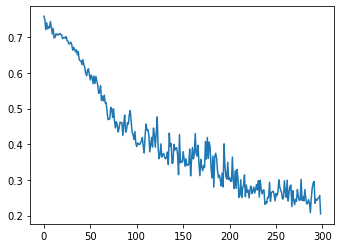

Train, it: 298 loss: 0.20
train loss:  0.23868438601493835


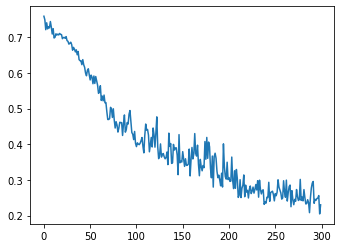

Train, it: 299 loss: 0.23


In [235]:
max_iter = 300
log_every = 100
eval_every = 100

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Train network
net.train()
for i in range(max_iter):
    train_iter.append(i)
    cur_loss = 0
    batch_iter = 0
    for j, batch_train in enumerate(dataloader_train):
        # Train
        inputs = get_variable(Variable(batch_train['image']))
        anno = get_variable(Variable(batch_train['annotation']))
        output = net(inputs)
        batch_loss = criterion(output, anno)

        cur_loss += float(get_numpy(batch_loss))
        batch_iter = j + 1
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        if j % 5 == 0:
            print("train loss: ", cur_loss / (j+1))

    scheduler.step()
    cur_loss /= batch_iter
    train_loss.append(cur_loss)
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iter, train_loss, label='train_loss')
    plt.show()
    # clear_output(wait=True)

    print("Train, it: {} loss: {:.2f}".format(i, train_loss[-1]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input shape: torch.Size([1, 3, 522, 775])


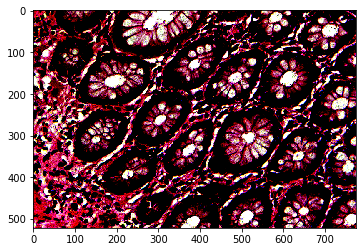

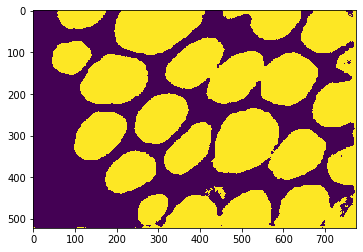

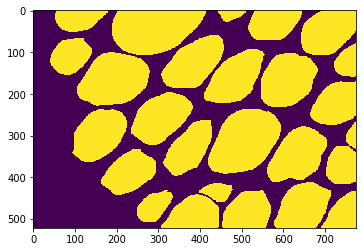

In [241]:
for batch_data in dataloader_observe:
    fig_img = plt.figure()
    inputs = get_variable(Variable(batch_data['image']))
    anno = batch_data['annotation']
    output = net(inputs)
    print('input shape:', inputs.shape)
    plt.imshow(get_numpy(inputs[0].permute(1, 2, 0)))
    plt.show()
    fig_img.suptitle('image')
    out1 = get_numpy(output[0][0])
    out1[out1>0] = 1
    out1[out1<0] = 0
    plt.imshow(out1)
    # plt.show()
    # out2 = get_numpy(output[0][1])
    # out2[out2>0] = 0
    # out2[out2<0] = 1
    # plt.imshow(out2)
    plt.show()
    plt.imshow(anno[0][0])
    plt.show()
    break

In [242]:
anno = get_variable(Variable(anno))
loss = criterion(output, anno)
print(get_numpy(loss))

0.20472658
